IDEAT: KMEANS VIX, Cap max weight for factor

<div style="font-size:14px;">
<strong>TO DO:</strong><br><br>
Tarkistaa ovatko regiimit oikein, exp. antaa ainoana kaikille neg sharpet<br>
Katsoa vielä financial turbulence koodi<br>
Data varmistukset (ei dataa tulevaisuudesta)<br><br>

<strong>Lisää features:</strong><br>
RSI<br>
Yield spread<br>
Muita??<br><br>

<strong>Muuta:</strong><br>
regiimi testaus drawdowneilla?<br><br>
regiimi specifi model ennustus?


<strong>Mallin kehitys:</strong><br>
1. Feature eliminointi<br>
2. Training interval<br>
3. Hyperparametrit
</div>



# GIT & imports

In [120]:
# # GitHub Repository Setup
#
# This cell navigates to `/content`, removes any previous clone of the repository,
# clones the latest version from GitHub, and lists the repository files.

# %%
%cd /content
!rm -rf Gradu
!git clone https://github.com/Elkkujou/Gradu.git
%cd /content/Gradu
!ls


/content
Cloning into 'Gradu'...
remote: Enumerating objects: 280, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 280 (delta 75), reused 0 (delta 0), pack-reused 136 (from 1)
Receiving objects: 100% (280/280), 33.04 MiB | 13.35 MiB/s, done.
Resolving deltas: 100% (133/133), done.
/content/Gradu
 chatti_RF.ipynb	       Regiimi_prediction.ipynb		    RF_Gradu.ipynb
'Financial turbulence.ipynb'   regime_prediction_famafrench.ipynb  'RF REGIIMI HYVÄ TRAINING.ipynb'
 FT_source.xlsx		       regime_prediction_msci.ipynb	   'RF_regime (3).ipynb'
 Gradient_boost_malli.ipynb    regime_pred.txt			    THE_ONE.xlsx


In [121]:
skip_training = False
use_regime_split = True


In [122]:
# # Import Required Libraries
#
# Import all necessary libraries for data manipulation, visualization,
# machine learning, and regression analysis.

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from tabulate import tabulate
from xgboost import XGBClassifier
from IPython.display import display, HTML


In [123]:
# Load and flatten the data
xls_file = pd.ExcelFile("/content/Gradu/THE_ONE.xlsx")
df = xls_file.parse("Ajodata_1963")
df.columns = df.columns.get_level_values(0)

print("Headers in the 'FF_Large_macro' sheet:")
print(df.columns)


#UNUSED: 'Financial Turbulance'
# 'H.Regimes' // TÄÄÄ RIKKI, EI OO NUMERO

FEATURES = [
    'CPI', 'PPI', 'PCE_Price_Index', 'Unemployment_Rate',
    'Labor_Force_Participation', 'Fed_Funds_Rate', 'Treasury_10Y',
    'Treasury_3Mo', 'Moody_Baa_Yield', 'UMich_Consumer_Sentiment',
    'M1_Money_Stock', 'M2_Money_Stock', 'Comm_Industrial_Loans',
    'Housing_Starts', 'New_1Fam_Houses_Sold', 'Industrial_Production',
    'Crude_Oil_WTI', 'Nonfarm_Payrolls'
]

# FEATURES = [
#     'New_1Fam_Houses_Sold',
#     'Comm_Industrial_Loans',
#     'M2_Money_Stock',
#     'Housing_Starts',
#     'Nonfarm_Payrolls',
#     'Crude_Oil_WTI',
#     'Industrial_Production',
#     'M1_Money_Stock',
#     'UMich_Consumer_Sentiment'
# ]


# Model split by column
REGIMES_COLUMN = 'Regimes'

# Used factors
FACTORS = [
    'SMB',
    'HML',
    'RMW',
    'CMA'
]


BENCHMARK = [
    'Mkt-RF'
]

# Convert the leftmost column (assumed to be the date column) to datetime
date_column = df.columns[0]
df[date_column] = pd.to_datetime(df[date_column])

# Retrieve first and last observation dates and count observations
first_date = df[date_column].iloc[0]
last_date = df[date_column].iloc[-1]
n_observations = len(df)

# Create a DataFrame with the information
info_df = pd.DataFrame({
    "Description": ["First observation date", "Last observation date", "Total number of observations"],
    "Value": [first_date, last_date, n_observations]
})

# Display the results as a neat HTML table
display(HTML(info_df.to_html(index=False, classes="table table-striped", border=0)))



Headers in the 'FF_Large_macro' sheet:
Index(['Date', 'CPI', 'PPI', 'PCE_Price_Index', 'Unemployment_Rate',
       'Labor_Force_Participation', 'Fed_Funds_Rate', 'Treasury_10Y',
       'Treasury_3Mo', 'Moody_Baa_Yield', 'UMich_Consumer_Sentiment',
       'M1_Money_Stock', 'M2_Money_Stock', 'Comm_Industrial_Loans',
       'Housing_Starts', 'New_1Fam_Houses_Sold', 'Industrial_Production',
       'Crude_Oil_WTI', 'Nonfarm_Payrolls', 'Mkt-RF', 'SMB', 'HML', 'RMW',
       'CMA', 'RF', 'Winning Factor', 'Unnamed: 26'],
      dtype='object')


Description,Value
First observation date,1963-07-31 00:00:00
Last observation date,2024-11-30 00:00:00
Total number of observations,737


In [129]:

# --- Define Helper Functions ---
def annualized_return(returns):
    """Compute the compounded annualized return (assuming monthly returns)."""
    return np.prod(1 + returns)**(12 / len(returns)) - 1

def compute_metrics(returns):
    """
    Compute key metrics for a returns series:
      - Annualized Return
      - Annualized Volatility (assuming monthly returns)
      - Total Cumulative Return
    """
    cumulative_returns = (1 + returns).cumprod()
    total_cum_return = cumulative_returns.iloc[-1] - 1
    ann_ret = annualized_return(returns)
    ann_vol = np.std(returns) * np.sqrt(12)
    return ann_ret, ann_vol, total_cum_return

# --- Compute Metrics for Benchmark and Each Factor ---
metrics = []

# Compute metrics for the benchmark.
benchmark_returns = df[BENCHMARK[0]]
bench_ann_ret, bench_ann_vol, bench_cum_return = compute_metrics(benchmark_returns)
metrics.append({
    "Strategy": "Benchmark",
    "Annualized Return": f"{bench_ann_ret*100:.2f}%",
    "Annualized Volatility": f"{bench_ann_vol*100:.2f}%",
    "Total Cumulative Return": f"{bench_cum_return*100:.2f}%"
})

# Compute metrics for each factor in FACTORS.
for factor in FACTORS:
    factor_returns = df[factor]
    factor_ann_ret, factor_ann_vol, factor_cum_return = compute_metrics(factor_returns)
    metrics.append({
        "Strategy": factor,
        "Annualized Return": f"{factor_ann_ret*100:.2f}%",
        "Annualized Volatility": f"{factor_ann_vol*100:.2f}%",
        "Total Cumulative Return": f"{factor_cum_return*100:.2f}%"
    })

# Create a DataFrame from the metrics.
metrics_df = pd.DataFrame(metrics)

# --- Display the Results as an HTML Table ---
display(HTML(metrics_df.to_html(index=False)))





Strategy,Annualized Return,Annualized Volatility,Total Cumulative Return
Benchmark,6.00%,15.51%,3483.52%
SMB,1.89%,10.55%,216.75%
HML,2.88%,10.37%,473.19%
RMW,3.14%,7.67%,568.93%
CMA,2.88%,7.18%,472.94%


In [130]:
# # Prepare Data for Model Training – Data Cleaning & Verification

# we keep all rows and compute the winning factor as the factor (from FACTORS) with the highest value in each row.

# Print the initial number of rows.
initial_rows = len(df)
print(f"Total number of rows before cleaning: {initial_rows}")

# Check missing values in feature columns (FEATURES) before dropping NAs.
missing_counts = df[FEATURES].isna().sum()
print("\nMissing values in feature columns before dropping NA:")
print(missing_counts)

# Save the number of rows before dropping NA and then drop rows with missing values in FEATURES.
initial_rows_features = len(df)
X = df[FEATURES].dropna()
rows_after_drop = len(X)
dropped_rows = initial_rows_features - rows_after_drop

if dropped_rows > 0:
    print(f"\nDropped {dropped_rows} rows due to missing values in feature columns.")
else:
    print("\nNo missing values found in feature columns. Data is clean.")

# Compute the Winning Factor by taking the column (from FACTORS) that has the maximum value in each row.
# This assumes that the FACTORS columns exist in df and contain numeric values.
df['Winning Factor'] = df[FACTORS].idxmax(axis=1)

# Define the target variable based on rows retained in X.
# The winning factor is encoded as a categorical variable.
y = df['Winning Factor'].astype('category').cat.codes.loc[X.index]
print("\nIndices aligned:", X.index.equals(y.index))

# Ensure the data is sorted by date.
df = df.sort_values('Date').reset_index(drop=True)

# Verify that all required columns exist.
# Here, we require the FEATURES columns, the 'USA Standard (Large+Mid Cap)' column,
# as well as all the FACTORS and the BENCHMARK columns.
required_columns = FEATURES + FACTORS + BENCHMARK
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")
print("\nParameters and dataset verified.")

# Compute the counts for each winning factor.
winning_factor_counts = df['Winning Factor'].value_counts()

# Compute total count and append it as the last row.
total_counts = winning_factor_counts.sum()
winning_factor_counts = pd.concat([winning_factor_counts, pd.Series({'Total': total_counts})])

# Print the counts with "Total" as the last row.
print("\nWinning Factor counts:")
print(winning_factor_counts)


Total number of rows before cleaning: 737

Missing values in feature columns before dropping NA:
CPI                          0
PPI                          0
PCE_Price_Index              0
Unemployment_Rate            0
Labor_Force_Participation    0
Fed_Funds_Rate               0
Treasury_10Y                 0
Treasury_3Mo                 0
Moody_Baa_Yield              0
UMich_Consumer_Sentiment     0
M1_Money_Stock               0
M2_Money_Stock               0
Comm_Industrial_Loans        0
Housing_Starts               0
New_1Fam_Houses_Sold         0
Industrial_Production        0
Crude_Oil_WTI                0
Nonfarm_Payrolls             0
dtype: int64

No missing values found in feature columns. Data is clean.

Indices aligned: True

Parameters and dataset verified.

Winning Factor counts:
SMB      227
RMW      217
HML      175
CMA      118
Total    737
dtype: int64


In [131]:
from IPython.display import display, HTML
start_row = 0     # Change this to your desired start row
end_row = 5    # Change this to your desired end row (or a large number to see all rows)

# Ensure that end_row does not exceed the total number of rows in the DataFrame.
if end_row > len(df):
    end_row = len(df)

# Print the preview.
print(f"\nPreview of the data from row {start_row} to row {end_row}:")
display(HTML(df.iloc[start_row:end_row].to_html(index=False)))



Preview of the data from row 0 to row 5:


Date,CPI,PPI,PCE_Price_Index,Unemployment_Rate,Labor_Force_Participation,Fed_Funds_Rate,Treasury_10Y,Treasury_3Mo,Moody_Baa_Yield,UMich_Consumer_Sentiment,M1_Money_Stock,M2_Money_Stock,Comm_Industrial_Loans,Housing_Starts,New_1Fam_Houses_Sold,Industrial_Production,Crude_Oil_WTI,Nonfarm_Payrolls,Mkt-RF,SMB,HML,RMW,CMA,RF,Winning Factor,Unnamed: 26,Winning Factor Encoded
1963-07-31,0.002614,0.003165,0.001992,5.6,58.7,3.49,4.00,3.32,4.84,91.7,0.005984,0.007135,0.004457,0.016373,0.264259,-0.003983,0.0,0.002383,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027,RMW,1963-08-01,2
1963-08-31,0.001955,-0.003155,0.001367,5.4,58.5,3.48,4.08,3.38,4.83,96.4,0.003305,0.006560,0.000210,0.015489,-0.142857,0.001999,0.0,0.002042,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025,HML,1963-09-01,1
1963-09-30,-0.000976,0.000000,-0.000186,5.5,58.7,3.50,4.11,3.45,4.84,96.4,0.001318,0.006257,0.006987,0.075656,0.035088,0.009970,0.0,0.002952,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027,CMA,1963-10-01,0
1963-10-31,0.000977,0.000000,0.001924,5.5,58.8,3.48,4.12,3.52,4.83,96.4,0.003947,0.005959,0.011814,0.009075,-0.038983,0.006911,0.0,0.003592,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029,RMW,1963-11-01,2
1963-11-30,0.000976,0.003165,0.001425,5.7,58.8,3.38,4.13,3.52,4.84,94.4,0.006553,0.008241,0.016407,-0.088252,0.021164,0.004902,0.0,-0.000489,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027,CMA,1963-12-01,0


In [127]:
# --- Regime Mapping & Conversion to Numeric Codes (Dynamic) ---

# Dynamically extract the unique values in the REGIMES_COLUMN.
unique_regimes = df[REGIMES_COLUMN].unique()

# Convert the Regimes column to a categorical type with the unique values, ordered alphabetically.
df[REGIMES_COLUMN] = pd.Categorical(df[REGIMES_COLUMN], categories=sorted(unique_regimes), ordered=True)

# Create a dictionary mapping numeric codes to the regime names based on the unique values.
regime_mapping = {i: cat for i, cat in enumerate(df[REGIMES_COLUMN].cat.categories)}

# Now encode the Regimes column as numeric codes.
df[REGIMES_COLUMN] = df[REGIMES_COLUMN].cat.codes

# Create a mapping from numeric codes to original regime names.
regime_short_mapping = {code: name for code, name in regime_mapping.items()}

# Calculate the number of observations for each regime using value_counts (without reindexing).
obs_counts = df[REGIMES_COLUMN].value_counts(sort=False)

# Create a DataFrame preview of the regime mapping, including observation counts.
mapping_table_data = []
for code in regime_mapping.keys():
    mapping_table_data.append({
        "Numeric Code": code,
        "Original Name": regime_mapping.get(code, "N/A"),
        "Observations": obs_counts.get(code, 0)
    })

# Append a row with the total observations.
total_obs = obs_counts.sum()
mapping_table_data.append({
    "Numeric Code": "",
    "Original Name": "Total",
    "Observations": total_obs
})

# Create the DataFrame for regime mapping preview and print.
regime_mapping_df = pd.DataFrame(mapping_table_data)

from tabulate import tabulate
print("Preview of Dynamic Regime Mapping:")
print(tabulate(regime_mapping_df, headers="keys", tablefmt="psql", showindex=False))


KeyError: 'Regimes'

In [132]:
# # Encode Winning Factor & Build Mappings
#
# Pre-encode the 'Winning Factor' column and create dictionaries to map full factor names
# to shorter names and numeric IDs for later reference.
# A preview of the mapping is printed in a neat table format.

# %%
df['Winning Factor Encoded'] = df['Winning Factor'].astype('category').cat.codes
winning_factor_categories = df['Winning Factor'].astype('category').cat.categories
winning_factor_mapping = {i: cat for i, cat in enumerate(winning_factor_categories)}

# Define a mapping for shorter factor names similar to your previous approach.
factor_rename_mapping = {
    'USA MOMENTUM Standard (Large+Mid Cap)': 'Momentum',
    'USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)': 'MinVol',
    'USA RISK WEIGHTED Standard (Large+Mid Cap)': 'RiskWeighted',
    'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)': 'SectorNeutral',
    'USA ENHANCED VALUE Standard (Large+Mid Cap)': 'EnhancedValue'
}

winning_factor_dict = {
    full_factor: {
        'full': full_factor,
        'short': factor_rename_mapping.get(full_factor, full_factor),
        'id': i
    }
    for i, full_factor in enumerate(winning_factor_categories)
}

# Create a small preview of the mapping as a DataFrame.
mapping_preview = pd.DataFrame([
    {"ID": d["id"], "Full Name": d["full"], "Short Name": d["short"]}
    for d in winning_factor_dict.values()
])

from tabulate import tabulate
print("Preview of Winning Factor Mapping:")
print(tabulate(mapping_preview, headers="keys", tablefmt="psql", showindex=False))


Preview of Winning Factor Mapping:
+------+-------------+--------------+
|   ID | Full Name   | Short Name   |
|------+-------------+--------------|
|    0 | CMA         | CMA          |
|    1 | HML         | HML          |
|    2 | RMW         | RMW          |
|    3 | SMB         | SMB          |
+------+-------------+--------------+


# Training

In [133]:
# # Define Rolling Window Parameters
#
# Set the training percentage, window size, and step size for the rolling window model training.

# %%
train_pct = 1.00  # Use 100% of data for rolling window training
train_end_idx = int(len(df) * train_pct)

window_size = 120   # Number of observations per training window
step_size = 1      # Step size for rolling window


### Hyperparameters Table

| Hyperparameter       | Purpose                                   | Common Choices                  |
|----------------------|-------------------------------------------|---------------------------------|
| `n_estimators`      | Number of trees                           | 100 (default), 200, 500         |
| `max_depth`         | Max tree depth                            | `None` (default), 10, 20        |
| `min_samples_split` | Min samples needed to split a node       | 2 (default), 10, 20             |
| `min_samples_leaf`  | Min samples in a leaf                    | 1 (default), 5, 10              |
| `max_features`      | Features per split                       | `'sqrt'` (default), `'log2'`, `None` |
| `bootstrap`         | Use bootstrap sampling                    | `True` (default), `False`       |
| `random_state`      | Set a random seed                         | `None`, 42, 0                   |
| `criterion`         | Splitting method                          | `'gini'` (default), `'entropy'` |
| `oob_score`        | Out-of-bag validation                     | `False` (default), `True`       |
| `n_jobs`           | Parallel training                         | `None`, `-1` (all CPUs)         |


In [134]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from IPython.display import display, HTML

# Parameters for the rolling window training:
overall_window_size = 120  # Number of observations per training window
min_data_threshold = 3     # Minimum observations required for training

# Create an empty list to store results.
results = []

# Ensure the dataset is sorted by Date.
df_sorted = df.sort_values('Date').reset_index(drop=True)

# Loop over test rows, starting at overall_window_size.
for i in range(overall_window_size, len(df_sorted)):
    # Get the current test row.
    test_row = df_sorted.iloc[i]
    Predicted_month = test_row['Date']

    # Define the training window (all rows prior to the test row).
    train_window = df_sorted.iloc[i - overall_window_size : i]

    # Skip iteration if training window is too small.
    if len(train_window) < min_data_threshold:
        print(f"Test row date {Predicted_month.date()}: only {len(train_window)} obs (<{min_data_threshold}), skipping.\n")
        continue

    # Ensure the last training observation is strictly before the test month (to avoid overlap).
    last_train_date = train_window['Date'].iloc[-1]
    if last_train_date.year == Predicted_month.year and last_train_date.month >= Predicted_month.month:
        print(f"Test row {Predicted_month.date()}: last training date {last_train_date.date()} is in the same month, skipping.\n")
        continue

    # Logging the training window details.
    train_start_date = train_window['Date'].iloc[0]
    train_end_date = last_train_date
    n_train = len(train_window)
    print(f"Test row date: {Predicted_month.date()}")
    print(f"  Training window: {train_start_date.date()} to {train_end_date.date()}, {n_train} obs")

    # Prepare training data and ensure features are numeric.
    X_train = train_window[FEATURES].dropna().astype(float)
    # IMPORTANT: Use the encoded target for training (ensure this column exists and is numeric)
    y_train = train_window['Winning Factor Encoded'].loc[X_train.index]
    if len(X_train) < min_data_threshold:
        print("   -> Not enough training data after dropping NAs, skipping iteration.\n")
        continue

    # Prepare test data and ensure features are numeric.
    X_test = test_row[FEATURES].to_frame().T.dropna().astype(float)
    if X_test.empty:
        print("   -> Test features are empty, skipping iteration.\n")
        continue

    # --- XGBoost Model (same hyperparameters as your GB) ---
    xgb_model = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        use_label_encoder=True,   # Allow XGBoost to encode string labels if needed
        eval_metric='mlogloss'
    )
    xgb_model.fit(X_train, y_train)

    # Get predicted probabilities and the predicted class for the test row.
    predicted_probabilities = xgb_model.predict_proba(X_test)[0]
    predicted_winner_num = xgb_model.classes_[predicted_probabilities.argmax()]
    # Map numeric prediction back to original factor name using winning_factor_mapping.
    predicted_winner = winning_factor_mapping.get(predicted_winner_num, predicted_winner_num)

    # Allocate return by weighting each factor's return by its predicted probability.
    # Use the mapping to convert each numeric class to its factor string before finding its index in FACTORS.
    full_probs = np.zeros(len(FACTORS))
    for cls, prob in zip(xgb_model.classes_, predicted_probabilities):
        # Convert numeric class to string.
        cls_str = winning_factor_mapping.get(cls, cls)
        try:
            idx = FACTORS.index(cls_str)
            full_probs[idx] = prob
        except ValueError:
            print(f"Warning: Class '{cls_str}' not found in FACTORS.")
    allocated_return = (full_probs * test_row[FACTORS].values).sum()

    # Store the results using the key names expected by your post-processing code.
    result = {
        'Regime': 'NoRegime',
        'Predicted_month': Predicted_month,
        'Train_Start_Date': train_start_date,
        'Train_End_Date': train_end_date,
        'Train_Count': len(X_train),
        'Feature_Importances': xgb_model.feature_importances_,
        'Predicted_Probabilities': full_probs,
        'Predicted_Winner': predicted_winner,
        'Allocated_Return': allocated_return,
        'Actual_Winner': test_row['Winning Factor']  # original string target for comparison
    }
    results.append(result)
    print(f"   -> XGBoost model trained and prediction made for {Predicted_month.date()}.\n")

# Convert the list of results into a DataFrame.
results_df = pd.DataFrame(results)
print("Headers in results_df:")
print(results_df.columns.tolist())

# Display first few rows for a quick check.
html_table = results_df.head(5).to_html(index=False)
display(HTML(html_table))

# Set flags so that your post-processing code knows expansions haven't been done yet.
feature_importances_expanded = False
probabilities_expanded = False
regimes_converted = False
predicted_winner_converted = False


Test row date: 1973-07-31
  Training window: 1963-07-31 to 1973-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1973-07-31.

Test row date: 1973-08-31
  Training window: 1963-08-31 to 1973-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1973-08-31.

Test row date: 1973-09-30
  Training window: 1963-09-30 to 1973-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1973-09-30.

Test row date: 1973-10-31
  Training window: 1963-10-31 to 1973-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1973-10-31.

Test row date: 1973-11-30
  Training window: 1963-11-30 to 1973-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1973-11-30.

Test row date: 1973-12-31
  Training window: 1963-12-31 to 1973-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1973-12-31.

Test row date: 1974-01-31
  Training window: 1964-01-31 to 1973-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1974-01-31.

Test row date: 1974-02-28
  Training window: 1964-02-29 to 1974-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1974-02-28.

Test row date: 1974-03-31
  Training window: 1964-03-31 to 1974-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1974-03-31.

Test row date: 1974-04-30
  Training window: 1964-04-30 to 1974-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1974-04-30.

Test row date: 1974-05-31
  Training window: 1964-05-31 to 1974-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1974-05-31.

Test row date: 1974-06-30
  Training window: 1964-06-30 to 1974-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1974-06-30.

Test row date: 1974-07-31
  Training window: 1964-07-31 to 1974-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1974-07-31.

Test row date: 1974-08-31
  Training window: 1964-08-31 to 1974-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1974-08-31.

Test row date: 1974-09-30
  Training window: 1964-09-30 to 1974-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1974-09-30.

Test row date: 1974-10-31
  Training window: 1964-10-31 to 1974-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1974-10-31.

Test row date: 1974-11-30
  Training window: 1964-11-30 to 1974-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1974-11-30.

Test row date: 1974-12-31
  Training window: 1964-12-31 to 1974-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1974-12-31.

Test row date: 1975-01-31
  Training window: 1965-01-31 to 1974-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1975-01-31.

Test row date: 1975-02-28
  Training window: 1965-02-28 to 1975-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1975-02-28.

Test row date: 1975-03-31
  Training window: 1965-03-31 to 1975-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1975-03-31.

Test row date: 1975-04-30
  Training window: 1965-04-30 to 1975-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1975-04-30.

Test row date: 1975-05-31
  Training window: 1965-05-31 to 1975-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1975-05-31.

Test row date: 1975-06-30
  Training window: 1965-06-30 to 1975-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1975-06-30.

Test row date: 1975-07-31
  Training window: 1965-07-31 to 1975-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1975-07-31.

Test row date: 1975-08-31
  Training window: 1965-08-31 to 1975-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1975-08-31.

Test row date: 1975-09-30
  Training window: 1965-09-30 to 1975-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1975-09-30.

Test row date: 1975-10-31
  Training window: 1965-10-31 to 1975-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1975-10-31.

Test row date: 1975-11-30
  Training window: 1965-11-30 to 1975-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1975-11-30.

Test row date: 1975-12-31
  Training window: 1965-12-31 to 1975-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1975-12-31.

Test row date: 1976-01-31
  Training window: 1966-01-31 to 1975-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1976-01-31.

Test row date: 1976-02-29
  Training window: 1966-02-28 to 1976-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1976-02-29.

Test row date: 1976-03-31
  Training window: 1966-03-31 to 1976-02-29, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1976-03-31.

Test row date: 1976-04-30
  Training window: 1966-04-30 to 1976-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1976-04-30.

Test row date: 1976-05-31
  Training window: 1966-05-31 to 1976-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1976-05-31.

Test row date: 1976-06-30
  Training window: 1966-06-30 to 1976-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1976-06-30.

Test row date: 1976-07-31
  Training window: 1966-07-31 to 1976-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1976-07-31.

Test row date: 1976-08-31
  Training window: 1966-08-31 to 1976-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1976-08-31.

Test row date: 1976-09-30
  Training window: 1966-09-30 to 1976-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1976-09-30.

Test row date: 1976-10-31
  Training window: 1966-10-31 to 1976-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1976-10-31.

Test row date: 1976-11-30
  Training window: 1966-11-30 to 1976-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1976-11-30.

Test row date: 1976-12-31
  Training window: 1966-12-31 to 1976-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1976-12-31.

Test row date: 1977-01-31
  Training window: 1967-01-31 to 1976-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1977-01-31.

Test row date: 1977-02-28
  Training window: 1967-02-28 to 1977-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1977-02-28.

Test row date: 1977-03-31
  Training window: 1967-03-31 to 1977-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1977-03-31.

Test row date: 1977-04-30
  Training window: 1967-04-30 to 1977-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1977-04-30.

Test row date: 1977-05-31
  Training window: 1967-05-31 to 1977-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1977-05-31.

Test row date: 1977-06-30
  Training window: 1967-06-30 to 1977-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1977-06-30.

Test row date: 1977-07-31
  Training window: 1967-07-31 to 1977-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1977-07-31.

Test row date: 1977-08-31
  Training window: 1967-08-31 to 1977-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1977-08-31.

Test row date: 1977-09-30
  Training window: 1967-09-30 to 1977-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1977-09-30.

Test row date: 1977-10-31
  Training window: 1967-10-31 to 1977-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1977-10-31.

Test row date: 1977-11-30
  Training window: 1967-11-30 to 1977-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1977-11-30.

Test row date: 1977-12-31
  Training window: 1967-12-31 to 1977-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1977-12-31.

Test row date: 1978-01-31
  Training window: 1968-01-31 to 1977-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1978-01-31.

Test row date: 1978-02-28
  Training window: 1968-02-29 to 1978-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1978-02-28.

Test row date: 1978-03-31
  Training window: 1968-03-31 to 1978-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1978-03-31.

Test row date: 1978-04-30
  Training window: 1968-04-30 to 1978-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1978-04-30.

Test row date: 1978-05-31
  Training window: 1968-05-31 to 1978-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1978-05-31.

Test row date: 1978-06-30
  Training window: 1968-06-30 to 1978-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1978-06-30.

Test row date: 1978-07-31
  Training window: 1968-07-31 to 1978-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1978-07-31.

Test row date: 1978-08-31
  Training window: 1968-08-31 to 1978-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1978-08-31.

Test row date: 1978-09-30
  Training window: 1968-09-30 to 1978-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1978-09-30.

Test row date: 1978-10-31
  Training window: 1968-10-31 to 1978-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1978-10-31.

Test row date: 1978-11-30
  Training window: 1968-11-30 to 1978-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1978-11-30.

Test row date: 1978-12-31
  Training window: 1968-12-31 to 1978-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1978-12-31.

Test row date: 1979-01-31
  Training window: 1969-01-31 to 1978-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1979-01-31.

Test row date: 1979-02-28
  Training window: 1969-02-28 to 1979-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1979-02-28.

Test row date: 1979-03-31
  Training window: 1969-03-31 to 1979-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1979-03-31.

Test row date: 1979-04-30
  Training window: 1969-04-30 to 1979-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1979-04-30.

Test row date: 1979-05-31
  Training window: 1969-05-31 to 1979-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1979-05-31.

Test row date: 1979-06-30
  Training window: 1969-06-30 to 1979-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1979-06-30.

Test row date: 1979-07-31
  Training window: 1969-07-31 to 1979-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1979-07-31.

Test row date: 1979-08-31
  Training window: 1969-08-31 to 1979-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1979-08-31.

Test row date: 1979-09-30
  Training window: 1969-09-30 to 1979-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1979-09-30.

Test row date: 1979-10-31
  Training window: 1969-10-31 to 1979-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1979-10-31.

Test row date: 1979-11-30
  Training window: 1969-11-30 to 1979-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1979-11-30.

Test row date: 1979-12-31
  Training window: 1969-12-31 to 1979-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1979-12-31.

Test row date: 1980-01-31
  Training window: 1970-01-31 to 1979-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1980-01-31.

Test row date: 1980-02-29
  Training window: 1970-02-28 to 1980-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1980-02-29.

Test row date: 1980-03-31
  Training window: 1970-03-31 to 1980-02-29, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1980-03-31.

Test row date: 1980-04-30
  Training window: 1970-04-30 to 1980-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1980-04-30.

Test row date: 1980-05-31
  Training window: 1970-05-31 to 1980-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1980-05-31.

Test row date: 1980-06-30
  Training window: 1970-06-30 to 1980-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1980-06-30.

Test row date: 1980-07-31
  Training window: 1970-07-31 to 1980-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1980-07-31.

Test row date: 1980-08-31
  Training window: 1970-08-31 to 1980-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1980-08-31.

Test row date: 1980-09-30
  Training window: 1970-09-30 to 1980-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1980-09-30.

Test row date: 1980-10-31
  Training window: 1970-10-31 to 1980-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1980-10-31.

Test row date: 1980-11-30
  Training window: 1970-11-30 to 1980-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1980-11-30.

Test row date: 1980-12-31
  Training window: 1970-12-31 to 1980-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1980-12-31.

Test row date: 1981-01-31
  Training window: 1971-01-31 to 1980-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1981-01-31.

Test row date: 1981-02-28
  Training window: 1971-02-28 to 1981-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1981-02-28.

Test row date: 1981-03-31
  Training window: 1971-03-31 to 1981-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1981-03-31.

Test row date: 1981-04-30
  Training window: 1971-04-30 to 1981-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1981-04-30.

Test row date: 1981-05-31
  Training window: 1971-05-31 to 1981-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1981-05-31.

Test row date: 1981-06-30
  Training window: 1971-06-30 to 1981-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1981-06-30.

Test row date: 1981-07-31
  Training window: 1971-07-31 to 1981-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1981-07-31.

Test row date: 1981-08-31
  Training window: 1971-08-31 to 1981-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1981-08-31.

Test row date: 1981-09-30
  Training window: 1971-09-30 to 1981-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1981-09-30.

Test row date: 1981-10-31
  Training window: 1971-10-31 to 1981-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1981-10-31.

Test row date: 1981-11-30
  Training window: 1971-11-30 to 1981-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1981-11-30.

Test row date: 1981-12-31
  Training window: 1971-12-31 to 1981-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1981-12-31.

Test row date: 1982-01-31
  Training window: 1972-01-31 to 1981-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1982-01-31.

Test row date: 1982-02-28
  Training window: 1972-02-29 to 1982-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1982-02-28.

Test row date: 1982-03-31
  Training window: 1972-03-31 to 1982-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1982-03-31.

Test row date: 1982-04-30
  Training window: 1972-04-30 to 1982-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1982-04-30.

Test row date: 1982-05-31
  Training window: 1972-05-31 to 1982-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1982-05-31.

Test row date: 1982-06-30
  Training window: 1972-06-30 to 1982-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1982-06-30.

Test row date: 1982-07-31
  Training window: 1972-07-31 to 1982-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1982-07-31.

Test row date: 1982-08-31
  Training window: 1972-08-31 to 1982-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1982-08-31.

Test row date: 1982-09-30
  Training window: 1972-09-30 to 1982-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1982-09-30.

Test row date: 1982-10-31
  Training window: 1972-10-31 to 1982-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1982-10-31.

Test row date: 1982-11-30
  Training window: 1972-11-30 to 1982-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1982-11-30.

Test row date: 1982-12-31
  Training window: 1972-12-31 to 1982-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1982-12-31.

Test row date: 1983-01-31
  Training window: 1973-01-31 to 1982-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1983-01-31.

Test row date: 1983-02-28
  Training window: 1973-02-28 to 1983-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1983-02-28.

Test row date: 1983-03-31
  Training window: 1973-03-31 to 1983-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1983-03-31.

Test row date: 1983-04-30
  Training window: 1973-04-30 to 1983-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1983-04-30.

Test row date: 1983-05-31
  Training window: 1973-05-31 to 1983-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1983-05-31.

Test row date: 1983-06-30
  Training window: 1973-06-30 to 1983-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1983-06-30.

Test row date: 1983-07-31
  Training window: 1973-07-31 to 1983-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1983-07-31.

Test row date: 1983-08-31
  Training window: 1973-08-31 to 1983-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1983-08-31.

Test row date: 1983-09-30
  Training window: 1973-09-30 to 1983-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1983-09-30.

Test row date: 1983-10-31
  Training window: 1973-10-31 to 1983-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1983-10-31.

Test row date: 1983-11-30
  Training window: 1973-11-30 to 1983-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1983-11-30.

Test row date: 1983-12-31
  Training window: 1973-12-31 to 1983-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1983-12-31.

Test row date: 1984-01-31
  Training window: 1974-01-31 to 1983-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1984-01-31.

Test row date: 1984-02-29
  Training window: 1974-02-28 to 1984-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1984-02-29.

Test row date: 1984-03-31
  Training window: 1974-03-31 to 1984-02-29, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1984-03-31.

Test row date: 1984-04-30
  Training window: 1974-04-30 to 1984-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1984-04-30.

Test row date: 1984-05-31
  Training window: 1974-05-31 to 1984-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1984-05-31.

Test row date: 1984-06-30
  Training window: 1974-06-30 to 1984-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1984-06-30.

Test row date: 1984-07-31
  Training window: 1974-07-31 to 1984-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1984-07-31.

Test row date: 1984-08-31
  Training window: 1974-08-31 to 1984-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1984-08-31.

Test row date: 1984-09-30
  Training window: 1974-09-30 to 1984-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1984-09-30.

Test row date: 1984-10-31
  Training window: 1974-10-31 to 1984-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1984-10-31.

Test row date: 1984-11-30
  Training window: 1974-11-30 to 1984-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1984-11-30.

Test row date: 1984-12-31
  Training window: 1974-12-31 to 1984-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1984-12-31.

Test row date: 1985-01-31
  Training window: 1975-01-31 to 1984-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1985-01-31.

Test row date: 1985-02-28
  Training window: 1975-02-28 to 1985-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1985-02-28.

Test row date: 1985-03-31
  Training window: 1975-03-31 to 1985-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1985-03-31.

Test row date: 1985-04-30
  Training window: 1975-04-30 to 1985-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1985-04-30.

Test row date: 1985-05-31
  Training window: 1975-05-31 to 1985-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1985-05-31.

Test row date: 1985-06-30
  Training window: 1975-06-30 to 1985-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1985-06-30.

Test row date: 1985-07-31
  Training window: 1975-07-31 to 1985-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1985-07-31.

Test row date: 1985-08-31
  Training window: 1975-08-31 to 1985-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1985-08-31.

Test row date: 1985-09-30
  Training window: 1975-09-30 to 1985-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1985-09-30.

Test row date: 1985-10-31
  Training window: 1975-10-31 to 1985-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1985-10-31.

Test row date: 1985-11-30
  Training window: 1975-11-30 to 1985-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1985-11-30.

Test row date: 1985-12-31
  Training window: 1975-12-31 to 1985-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1985-12-31.

Test row date: 1986-01-31
  Training window: 1976-01-31 to 1985-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1986-01-31.

Test row date: 1986-02-28
  Training window: 1976-02-29 to 1986-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1986-02-28.

Test row date: 1986-03-31
  Training window: 1976-03-31 to 1986-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1986-03-31.

Test row date: 1986-04-30
  Training window: 1976-04-30 to 1986-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1986-04-30.

Test row date: 1986-05-31
  Training window: 1976-05-31 to 1986-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1986-05-31.

Test row date: 1986-06-30
  Training window: 1976-06-30 to 1986-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1986-06-30.

Test row date: 1986-07-31
  Training window: 1976-07-31 to 1986-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1986-07-31.

Test row date: 1986-08-31
  Training window: 1976-08-31 to 1986-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1986-08-31.

Test row date: 1986-09-30
  Training window: 1976-09-30 to 1986-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1986-09-30.

Test row date: 1986-10-31
  Training window: 1976-10-31 to 1986-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1986-10-31.

Test row date: 1986-11-30
  Training window: 1976-11-30 to 1986-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1986-11-30.

Test row date: 1986-12-31
  Training window: 1976-12-31 to 1986-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1986-12-31.

Test row date: 1987-01-31
  Training window: 1977-01-31 to 1986-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1987-01-31.

Test row date: 1987-02-28
  Training window: 1977-02-28 to 1987-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1987-02-28.

Test row date: 1987-03-31
  Training window: 1977-03-31 to 1987-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1987-03-31.

Test row date: 1987-04-30
  Training window: 1977-04-30 to 1987-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1987-04-30.

Test row date: 1987-05-31
  Training window: 1977-05-31 to 1987-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1987-05-31.

Test row date: 1987-06-30
  Training window: 1977-06-30 to 1987-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1987-06-30.

Test row date: 1987-07-31
  Training window: 1977-07-31 to 1987-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1987-07-31.

Test row date: 1987-08-31
  Training window: 1977-08-31 to 1987-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1987-08-31.

Test row date: 1987-09-30
  Training window: 1977-09-30 to 1987-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1987-09-30.

Test row date: 1987-10-31
  Training window: 1977-10-31 to 1987-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1987-10-31.

Test row date: 1987-11-30
  Training window: 1977-11-30 to 1987-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1987-11-30.

Test row date: 1987-12-31
  Training window: 1977-12-31 to 1987-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1987-12-31.

Test row date: 1988-01-31
  Training window: 1978-01-31 to 1987-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1988-01-31.

Test row date: 1988-02-29
  Training window: 1978-02-28 to 1988-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1988-02-29.

Test row date: 1988-03-31
  Training window: 1978-03-31 to 1988-02-29, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1988-03-31.

Test row date: 1988-04-30
  Training window: 1978-04-30 to 1988-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1988-04-30.

Test row date: 1988-05-31
  Training window: 1978-05-31 to 1988-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1988-05-31.

Test row date: 1988-06-30
  Training window: 1978-06-30 to 1988-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1988-06-30.

Test row date: 1988-07-31
  Training window: 1978-07-31 to 1988-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1988-07-31.

Test row date: 1988-08-31
  Training window: 1978-08-31 to 1988-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1988-08-31.

Test row date: 1988-09-30
  Training window: 1978-09-30 to 1988-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1988-09-30.

Test row date: 1988-10-31
  Training window: 1978-10-31 to 1988-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1988-10-31.

Test row date: 1988-11-30
  Training window: 1978-11-30 to 1988-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1988-11-30.

Test row date: 1988-12-31
  Training window: 1978-12-31 to 1988-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1988-12-31.

Test row date: 1989-01-31
  Training window: 1979-01-31 to 1988-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1989-01-31.

Test row date: 1989-02-28
  Training window: 1979-02-28 to 1989-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1989-02-28.

Test row date: 1989-03-31
  Training window: 1979-03-31 to 1989-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1989-03-31.

Test row date: 1989-04-30
  Training window: 1979-04-30 to 1989-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1989-04-30.

Test row date: 1989-05-31
  Training window: 1979-05-31 to 1989-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1989-05-31.

Test row date: 1989-06-30
  Training window: 1979-06-30 to 1989-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1989-06-30.

Test row date: 1989-07-31
  Training window: 1979-07-31 to 1989-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1989-07-31.

Test row date: 1989-08-31
  Training window: 1979-08-31 to 1989-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1989-08-31.

Test row date: 1989-09-30
  Training window: 1979-09-30 to 1989-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1989-09-30.

Test row date: 1989-10-31
  Training window: 1979-10-31 to 1989-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1989-10-31.

Test row date: 1989-11-30
  Training window: 1979-11-30 to 1989-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1989-11-30.

Test row date: 1989-12-31
  Training window: 1979-12-31 to 1989-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1989-12-31.

Test row date: 1990-01-31
  Training window: 1980-01-31 to 1989-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1990-01-31.

Test row date: 1990-02-28
  Training window: 1980-02-29 to 1990-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1990-02-28.

Test row date: 1990-03-31
  Training window: 1980-03-31 to 1990-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1990-03-31.

Test row date: 1990-04-30
  Training window: 1980-04-30 to 1990-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1990-04-30.

Test row date: 1990-05-31
  Training window: 1980-05-31 to 1990-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1990-05-31.

Test row date: 1990-06-30
  Training window: 1980-06-30 to 1990-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1990-06-30.

Test row date: 1990-07-31
  Training window: 1980-07-31 to 1990-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1990-07-31.

Test row date: 1990-08-31
  Training window: 1980-08-31 to 1990-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1990-08-31.

Test row date: 1990-09-30
  Training window: 1980-09-30 to 1990-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1990-09-30.

Test row date: 1990-10-31
  Training window: 1980-10-31 to 1990-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1990-10-31.

Test row date: 1990-11-30
  Training window: 1980-11-30 to 1990-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1990-11-30.

Test row date: 1990-12-31
  Training window: 1980-12-31 to 1990-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1990-12-31.

Test row date: 1991-01-31
  Training window: 1981-01-31 to 1990-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1991-01-31.

Test row date: 1991-02-28
  Training window: 1981-02-28 to 1991-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1991-02-28.

Test row date: 1991-03-31
  Training window: 1981-03-31 to 1991-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1991-03-31.

Test row date: 1991-04-30
  Training window: 1981-04-30 to 1991-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1991-04-30.

Test row date: 1991-05-31
  Training window: 1981-05-31 to 1991-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1991-05-31.

Test row date: 1991-06-30
  Training window: 1981-06-30 to 1991-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1991-06-30.

Test row date: 1991-07-31
  Training window: 1981-07-31 to 1991-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1991-07-31.

Test row date: 1991-08-31
  Training window: 1981-08-31 to 1991-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1991-08-31.

Test row date: 1991-09-30
  Training window: 1981-09-30 to 1991-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1991-09-30.

Test row date: 1991-10-31
  Training window: 1981-10-31 to 1991-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1991-10-31.

Test row date: 1991-11-30
  Training window: 1981-11-30 to 1991-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1991-11-30.

Test row date: 1991-12-31
  Training window: 1981-12-31 to 1991-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1991-12-31.

Test row date: 1992-01-31
  Training window: 1982-01-31 to 1991-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1992-01-31.

Test row date: 1992-02-29
  Training window: 1982-02-28 to 1992-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1992-02-29.

Test row date: 1992-03-31
  Training window: 1982-03-31 to 1992-02-29, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1992-03-31.

Test row date: 1992-04-30
  Training window: 1982-04-30 to 1992-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1992-04-30.

Test row date: 1992-05-31
  Training window: 1982-05-31 to 1992-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1992-05-31.

Test row date: 1992-06-30
  Training window: 1982-06-30 to 1992-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1992-06-30.

Test row date: 1992-07-31
  Training window: 1982-07-31 to 1992-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1992-07-31.

Test row date: 1992-08-31
  Training window: 1982-08-31 to 1992-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1992-08-31.

Test row date: 1992-09-30
  Training window: 1982-09-30 to 1992-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1992-09-30.

Test row date: 1992-10-31
  Training window: 1982-10-31 to 1992-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1992-10-31.

Test row date: 1992-11-30
  Training window: 1982-11-30 to 1992-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1992-11-30.

Test row date: 1992-12-31
  Training window: 1982-12-31 to 1992-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1992-12-31.

Test row date: 1993-01-31
  Training window: 1983-01-31 to 1992-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1993-01-31.

Test row date: 1993-02-28
  Training window: 1983-02-28 to 1993-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1993-02-28.

Test row date: 1993-03-31
  Training window: 1983-03-31 to 1993-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1993-03-31.

Test row date: 1993-04-30
  Training window: 1983-04-30 to 1993-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1993-04-30.

Test row date: 1993-05-31
  Training window: 1983-05-31 to 1993-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1993-05-31.

Test row date: 1993-06-30
  Training window: 1983-06-30 to 1993-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1993-06-30.

Test row date: 1993-07-31
  Training window: 1983-07-31 to 1993-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1993-07-31.

Test row date: 1993-08-31
  Training window: 1983-08-31 to 1993-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1993-08-31.

Test row date: 1993-09-30
  Training window: 1983-09-30 to 1993-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1993-09-30.

Test row date: 1993-10-31
  Training window: 1983-10-31 to 1993-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1993-10-31.

Test row date: 1993-11-30
  Training window: 1983-11-30 to 1993-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1993-11-30.

Test row date: 1993-12-31
  Training window: 1983-12-31 to 1993-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1993-12-31.

Test row date: 1994-01-31
  Training window: 1984-01-31 to 1993-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1994-01-31.

Test row date: 1994-02-28
  Training window: 1984-02-29 to 1994-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1994-02-28.

Test row date: 1994-03-31
  Training window: 1984-03-31 to 1994-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1994-03-31.

Test row date: 1994-04-30
  Training window: 1984-04-30 to 1994-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1994-04-30.

Test row date: 1994-05-31
  Training window: 1984-05-31 to 1994-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1994-05-31.

Test row date: 1994-06-30
  Training window: 1984-06-30 to 1994-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1994-06-30.

Test row date: 1994-07-31
  Training window: 1984-07-31 to 1994-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1994-07-31.

Test row date: 1994-08-31
  Training window: 1984-08-31 to 1994-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1994-08-31.

Test row date: 1994-09-30
  Training window: 1984-09-30 to 1994-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1994-09-30.

Test row date: 1994-10-31
  Training window: 1984-10-31 to 1994-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1994-10-31.

Test row date: 1994-11-30
  Training window: 1984-11-30 to 1994-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1994-11-30.

Test row date: 1994-12-31
  Training window: 1984-12-31 to 1994-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1994-12-31.

Test row date: 1995-01-31
  Training window: 1985-01-31 to 1994-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1995-01-31.

Test row date: 1995-02-28
  Training window: 1985-02-28 to 1995-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1995-02-28.

Test row date: 1995-03-31
  Training window: 1985-03-31 to 1995-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1995-03-31.

Test row date: 1995-04-30
  Training window: 1985-04-30 to 1995-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1995-04-30.

Test row date: 1995-05-31
  Training window: 1985-05-31 to 1995-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1995-05-31.

Test row date: 1995-06-30
  Training window: 1985-06-30 to 1995-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1995-06-30.

Test row date: 1995-07-31
  Training window: 1985-07-31 to 1995-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1995-07-31.

Test row date: 1995-08-31
  Training window: 1985-08-31 to 1995-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1995-08-31.

Test row date: 1995-09-30
  Training window: 1985-09-30 to 1995-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1995-09-30.

Test row date: 1995-10-31
  Training window: 1985-10-31 to 1995-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1995-10-31.

Test row date: 1995-11-30
  Training window: 1985-11-30 to 1995-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1995-11-30.

Test row date: 1995-12-31
  Training window: 1985-12-31 to 1995-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1995-12-31.

Test row date: 1996-01-31
  Training window: 1986-01-31 to 1995-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1996-01-31.

Test row date: 1996-02-29
  Training window: 1986-02-28 to 1996-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1996-02-29.

Test row date: 1996-03-31
  Training window: 1986-03-31 to 1996-02-29, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1996-03-31.

Test row date: 1996-04-30
  Training window: 1986-04-30 to 1996-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1996-04-30.

Test row date: 1996-05-31
  Training window: 1986-05-31 to 1996-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1996-05-31.

Test row date: 1996-06-30
  Training window: 1986-06-30 to 1996-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1996-06-30.

Test row date: 1996-07-31
  Training window: 1986-07-31 to 1996-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1996-07-31.

Test row date: 1996-08-31
  Training window: 1986-08-31 to 1996-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1996-08-31.

Test row date: 1996-09-30
  Training window: 1986-09-30 to 1996-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1996-09-30.

Test row date: 1996-10-31
  Training window: 1986-10-31 to 1996-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1996-10-31.

Test row date: 1996-11-30
  Training window: 1986-11-30 to 1996-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1996-11-30.

Test row date: 1996-12-31
  Training window: 1986-12-31 to 1996-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1996-12-31.

Test row date: 1997-01-31
  Training window: 1987-01-31 to 1996-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1997-01-31.

Test row date: 1997-02-28
  Training window: 1987-02-28 to 1997-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1997-02-28.

Test row date: 1997-03-31
  Training window: 1987-03-31 to 1997-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1997-03-31.

Test row date: 1997-04-30
  Training window: 1987-04-30 to 1997-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1997-04-30.

Test row date: 1997-05-31
  Training window: 1987-05-31 to 1997-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1997-05-31.

Test row date: 1997-06-30
  Training window: 1987-06-30 to 1997-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1997-06-30.

Test row date: 1997-07-31
  Training window: 1987-07-31 to 1997-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1997-07-31.

Test row date: 1997-08-31
  Training window: 1987-08-31 to 1997-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1997-08-31.

Test row date: 1997-09-30
  Training window: 1987-09-30 to 1997-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1997-09-30.

Test row date: 1997-10-31
  Training window: 1987-10-31 to 1997-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1997-10-31.

Test row date: 1997-11-30
  Training window: 1987-11-30 to 1997-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1997-11-30.

Test row date: 1997-12-31
  Training window: 1987-12-31 to 1997-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1997-12-31.

Test row date: 1998-01-31
  Training window: 1988-01-31 to 1997-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1998-01-31.

Test row date: 1998-02-28
  Training window: 1988-02-29 to 1998-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1998-02-28.

Test row date: 1998-03-31
  Training window: 1988-03-31 to 1998-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1998-03-31.

Test row date: 1998-04-30
  Training window: 1988-04-30 to 1998-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1998-04-30.

Test row date: 1998-05-31
  Training window: 1988-05-31 to 1998-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1998-05-31.

Test row date: 1998-06-30
  Training window: 1988-06-30 to 1998-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1998-06-30.

Test row date: 1998-07-31
  Training window: 1988-07-31 to 1998-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1998-07-31.

Test row date: 1998-08-31
  Training window: 1988-08-31 to 1998-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1998-08-31.

Test row date: 1998-09-30
  Training window: 1988-09-30 to 1998-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1998-09-30.

Test row date: 1998-10-31
  Training window: 1988-10-31 to 1998-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1998-10-31.

Test row date: 1998-11-30
  Training window: 1988-11-30 to 1998-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1998-11-30.

Test row date: 1998-12-31
  Training window: 1988-12-31 to 1998-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1998-12-31.

Test row date: 1999-01-31
  Training window: 1989-01-31 to 1998-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1999-01-31.

Test row date: 1999-02-28
  Training window: 1989-02-28 to 1999-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1999-02-28.

Test row date: 1999-03-31
  Training window: 1989-03-31 to 1999-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1999-03-31.

Test row date: 1999-04-30
  Training window: 1989-04-30 to 1999-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1999-04-30.

Test row date: 1999-05-31
  Training window: 1989-05-31 to 1999-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1999-05-31.

Test row date: 1999-06-30
  Training window: 1989-06-30 to 1999-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1999-06-30.

Test row date: 1999-07-31
  Training window: 1989-07-31 to 1999-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1999-07-31.

Test row date: 1999-08-31
  Training window: 1989-08-31 to 1999-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1999-08-31.

Test row date: 1999-09-30
  Training window: 1989-09-30 to 1999-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1999-09-30.

Test row date: 1999-10-31
  Training window: 1989-10-31 to 1999-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1999-10-31.

Test row date: 1999-11-30
  Training window: 1989-11-30 to 1999-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1999-11-30.

Test row date: 1999-12-31
  Training window: 1989-12-31 to 1999-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 1999-12-31.

Test row date: 2000-01-31
  Training window: 1990-01-31 to 1999-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2000-01-31.

Test row date: 2000-02-29
  Training window: 1990-02-28 to 2000-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2000-02-29.

Test row date: 2000-03-31
  Training window: 1990-03-31 to 2000-02-29, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2000-03-31.

Test row date: 2000-04-30
  Training window: 1990-04-30 to 2000-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2000-04-30.

Test row date: 2000-05-31
  Training window: 1990-05-31 to 2000-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2000-05-31.

Test row date: 2000-06-30
  Training window: 1990-06-30 to 2000-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2000-06-30.

Test row date: 2000-07-31
  Training window: 1990-07-31 to 2000-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2000-07-31.

Test row date: 2000-08-31
  Training window: 1990-08-31 to 2000-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2000-08-31.

Test row date: 2000-09-30
  Training window: 1990-09-30 to 2000-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2000-09-30.

Test row date: 2000-10-31
  Training window: 1990-10-31 to 2000-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2000-10-31.

Test row date: 2000-11-30
  Training window: 1990-11-30 to 2000-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2000-11-30.

Test row date: 2000-12-31
  Training window: 1990-12-31 to 2000-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2000-12-31.

Test row date: 2001-01-31
  Training window: 1991-01-31 to 2000-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2001-01-31.

Test row date: 2001-02-28
  Training window: 1991-02-28 to 2001-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2001-02-28.

Test row date: 2001-03-31
  Training window: 1991-03-31 to 2001-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2001-03-31.

Test row date: 2001-04-30
  Training window: 1991-04-30 to 2001-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2001-04-30.

Test row date: 2001-05-31
  Training window: 1991-05-31 to 2001-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2001-05-31.

Test row date: 2001-06-30
  Training window: 1991-06-30 to 2001-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2001-06-30.

Test row date: 2001-07-31
  Training window: 1991-07-31 to 2001-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2001-07-31.

Test row date: 2001-08-31
  Training window: 1991-08-31 to 2001-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2001-08-31.

Test row date: 2001-09-30
  Training window: 1991-09-30 to 2001-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2001-09-30.

Test row date: 2001-10-31
  Training window: 1991-10-31 to 2001-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2001-10-31.

Test row date: 2001-11-30
  Training window: 1991-11-30 to 2001-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2001-11-30.

Test row date: 2001-12-31
  Training window: 1991-12-31 to 2001-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2001-12-31.

Test row date: 2002-01-31
  Training window: 1992-01-31 to 2001-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2002-01-31.

Test row date: 2002-02-28
  Training window: 1992-02-29 to 2002-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2002-02-28.

Test row date: 2002-03-31
  Training window: 1992-03-31 to 2002-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2002-03-31.

Test row date: 2002-04-30
  Training window: 1992-04-30 to 2002-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2002-04-30.

Test row date: 2002-05-31
  Training window: 1992-05-31 to 2002-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2002-05-31.

Test row date: 2002-06-30
  Training window: 1992-06-30 to 2002-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2002-06-30.

Test row date: 2002-07-31
  Training window: 1992-07-31 to 2002-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2002-07-31.

Test row date: 2002-08-31
  Training window: 1992-08-31 to 2002-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2002-08-31.

Test row date: 2002-09-30
  Training window: 1992-09-30 to 2002-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2002-09-30.

Test row date: 2002-10-31
  Training window: 1992-10-31 to 2002-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2002-10-31.

Test row date: 2002-11-30
  Training window: 1992-11-30 to 2002-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2002-11-30.

Test row date: 2002-12-31
  Training window: 1992-12-31 to 2002-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2002-12-31.

Test row date: 2003-01-31
  Training window: 1993-01-31 to 2002-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2003-01-31.

Test row date: 2003-02-28
  Training window: 1993-02-28 to 2003-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2003-02-28.

Test row date: 2003-03-31
  Training window: 1993-03-31 to 2003-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2003-03-31.

Test row date: 2003-04-30
  Training window: 1993-04-30 to 2003-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2003-04-30.

Test row date: 2003-05-31
  Training window: 1993-05-31 to 2003-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2003-05-31.

Test row date: 2003-06-30
  Training window: 1993-06-30 to 2003-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2003-06-30.

Test row date: 2003-07-31
  Training window: 1993-07-31 to 2003-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2003-07-31.

Test row date: 2003-08-31
  Training window: 1993-08-31 to 2003-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2003-08-31.

Test row date: 2003-09-30
  Training window: 1993-09-30 to 2003-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2003-09-30.

Test row date: 2003-10-31
  Training window: 1993-10-31 to 2003-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2003-10-31.

Test row date: 2003-11-30
  Training window: 1993-11-30 to 2003-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2003-11-30.

Test row date: 2003-12-31
  Training window: 1993-12-31 to 2003-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2003-12-31.

Test row date: 2004-01-31
  Training window: 1994-01-31 to 2003-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2004-01-31.

Test row date: 2004-02-29
  Training window: 1994-02-28 to 2004-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2004-02-29.

Test row date: 2004-03-31
  Training window: 1994-03-31 to 2004-02-29, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2004-03-31.

Test row date: 2004-04-30
  Training window: 1994-04-30 to 2004-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2004-04-30.

Test row date: 2004-05-31
  Training window: 1994-05-31 to 2004-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2004-05-31.

Test row date: 2004-06-30
  Training window: 1994-06-30 to 2004-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2004-06-30.

Test row date: 2004-07-31
  Training window: 1994-07-31 to 2004-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2004-07-31.

Test row date: 2004-08-31
  Training window: 1994-08-31 to 2004-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2004-08-31.

Test row date: 2004-09-30
  Training window: 1994-09-30 to 2004-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2004-09-30.

Test row date: 2004-10-31
  Training window: 1994-10-31 to 2004-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2004-10-31.

Test row date: 2004-11-30
  Training window: 1994-11-30 to 2004-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2004-11-30.

Test row date: 2004-12-31
  Training window: 1994-12-31 to 2004-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2004-12-31.

Test row date: 2005-01-31
  Training window: 1995-01-31 to 2004-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2005-01-31.

Test row date: 2005-02-28
  Training window: 1995-02-28 to 2005-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2005-02-28.

Test row date: 2005-03-31
  Training window: 1995-03-31 to 2005-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2005-03-31.

Test row date: 2005-04-30
  Training window: 1995-04-30 to 2005-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2005-04-30.

Test row date: 2005-05-31
  Training window: 1995-05-31 to 2005-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2005-05-31.

Test row date: 2005-06-30
  Training window: 1995-06-30 to 2005-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2005-06-30.

Test row date: 2005-07-31
  Training window: 1995-07-31 to 2005-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2005-07-31.

Test row date: 2005-08-31
  Training window: 1995-08-31 to 2005-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2005-08-31.

Test row date: 2005-09-30
  Training window: 1995-09-30 to 2005-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2005-09-30.

Test row date: 2005-10-31
  Training window: 1995-10-31 to 2005-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2005-10-31.

Test row date: 2005-11-30
  Training window: 1995-11-30 to 2005-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2005-11-30.

Test row date: 2005-12-31
  Training window: 1995-12-31 to 2005-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2005-12-31.

Test row date: 2006-01-31
  Training window: 1996-01-31 to 2005-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2006-01-31.

Test row date: 2006-02-28
  Training window: 1996-02-29 to 2006-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2006-02-28.

Test row date: 2006-03-31
  Training window: 1996-03-31 to 2006-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2006-03-31.

Test row date: 2006-04-30
  Training window: 1996-04-30 to 2006-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2006-04-30.

Test row date: 2006-05-31
  Training window: 1996-05-31 to 2006-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2006-05-31.

Test row date: 2006-06-30
  Training window: 1996-06-30 to 2006-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2006-06-30.

Test row date: 2006-07-31
  Training window: 1996-07-31 to 2006-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2006-07-31.

Test row date: 2006-08-31
  Training window: 1996-08-31 to 2006-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2006-08-31.

Test row date: 2006-09-30
  Training window: 1996-09-30 to 2006-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2006-09-30.

Test row date: 2006-10-31
  Training window: 1996-10-31 to 2006-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2006-10-31.

Test row date: 2006-11-30
  Training window: 1996-11-30 to 2006-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2006-11-30.

Test row date: 2006-12-31
  Training window: 1996-12-31 to 2006-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2006-12-31.

Test row date: 2007-01-31
  Training window: 1997-01-31 to 2006-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2007-01-31.

Test row date: 2007-02-28
  Training window: 1997-02-28 to 2007-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2007-02-28.

Test row date: 2007-03-31
  Training window: 1997-03-31 to 2007-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2007-03-31.

Test row date: 2007-04-30
  Training window: 1997-04-30 to 2007-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2007-04-30.

Test row date: 2007-05-31
  Training window: 1997-05-31 to 2007-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2007-05-31.

Test row date: 2007-06-30
  Training window: 1997-06-30 to 2007-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2007-06-30.

Test row date: 2007-07-31
  Training window: 1997-07-31 to 2007-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2007-07-31.

Test row date: 2007-08-31
  Training window: 1997-08-31 to 2007-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2007-08-31.

Test row date: 2007-09-30
  Training window: 1997-09-30 to 2007-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2007-09-30.

Test row date: 2007-10-31
  Training window: 1997-10-31 to 2007-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2007-10-31.

Test row date: 2007-11-30
  Training window: 1997-11-30 to 2007-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2007-11-30.

Test row date: 2007-12-31
  Training window: 1997-12-31 to 2007-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2007-12-31.

Test row date: 2008-01-31
  Training window: 1998-01-31 to 2007-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2008-01-31.

Test row date: 2008-02-29
  Training window: 1998-02-28 to 2008-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2008-02-29.

Test row date: 2008-03-31
  Training window: 1998-03-31 to 2008-02-29, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2008-03-31.

Test row date: 2008-04-30
  Training window: 1998-04-30 to 2008-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2008-04-30.

Test row date: 2008-05-31
  Training window: 1998-05-31 to 2008-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2008-05-31.

Test row date: 2008-06-30
  Training window: 1998-06-30 to 2008-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2008-06-30.

Test row date: 2008-07-31
  Training window: 1998-07-31 to 2008-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2008-07-31.

Test row date: 2008-08-31
  Training window: 1998-08-31 to 2008-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2008-08-31.

Test row date: 2008-09-30
  Training window: 1998-09-30 to 2008-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2008-09-30.

Test row date: 2008-10-31
  Training window: 1998-10-31 to 2008-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2008-10-31.

Test row date: 2008-11-30
  Training window: 1998-11-30 to 2008-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2008-11-30.

Test row date: 2008-12-31
  Training window: 1998-12-31 to 2008-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2008-12-31.

Test row date: 2009-01-31
  Training window: 1999-01-31 to 2008-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2009-01-31.

Test row date: 2009-02-28
  Training window: 1999-02-28 to 2009-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2009-02-28.

Test row date: 2009-03-31
  Training window: 1999-03-31 to 2009-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2009-03-31.

Test row date: 2009-04-30
  Training window: 1999-04-30 to 2009-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2009-04-30.

Test row date: 2009-05-31
  Training window: 1999-05-31 to 2009-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2009-05-31.

Test row date: 2009-06-30
  Training window: 1999-06-30 to 2009-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2009-06-30.

Test row date: 2009-07-31
  Training window: 1999-07-31 to 2009-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2009-07-31.

Test row date: 2009-08-31
  Training window: 1999-08-31 to 2009-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2009-08-31.

Test row date: 2009-09-30
  Training window: 1999-09-30 to 2009-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2009-09-30.

Test row date: 2009-10-31
  Training window: 1999-10-31 to 2009-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2009-10-31.

Test row date: 2009-11-30
  Training window: 1999-11-30 to 2009-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2009-11-30.

Test row date: 2009-12-31
  Training window: 1999-12-31 to 2009-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2009-12-31.

Test row date: 2010-01-31
  Training window: 2000-01-31 to 2009-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2010-01-31.

Test row date: 2010-02-28
  Training window: 2000-02-29 to 2010-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2010-02-28.

Test row date: 2010-03-31
  Training window: 2000-03-31 to 2010-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2010-03-31.

Test row date: 2010-04-30
  Training window: 2000-04-30 to 2010-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2010-04-30.

Test row date: 2010-05-31
  Training window: 2000-05-31 to 2010-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2010-05-31.

Test row date: 2010-06-30
  Training window: 2000-06-30 to 2010-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2010-06-30.

Test row date: 2010-07-31
  Training window: 2000-07-31 to 2010-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2010-07-31.

Test row date: 2010-08-31
  Training window: 2000-08-31 to 2010-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2010-08-31.

Test row date: 2010-09-30
  Training window: 2000-09-30 to 2010-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2010-09-30.

Test row date: 2010-10-31
  Training window: 2000-10-31 to 2010-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2010-10-31.

Test row date: 2010-11-30
  Training window: 2000-11-30 to 2010-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2010-11-30.

Test row date: 2010-12-31
  Training window: 2000-12-31 to 2010-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2010-12-31.

Test row date: 2011-01-31
  Training window: 2001-01-31 to 2010-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2011-01-31.

Test row date: 2011-02-28
  Training window: 2001-02-28 to 2011-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2011-02-28.

Test row date: 2011-03-31
  Training window: 2001-03-31 to 2011-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2011-03-31.

Test row date: 2011-04-30
  Training window: 2001-04-30 to 2011-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2011-04-30.

Test row date: 2011-05-31
  Training window: 2001-05-31 to 2011-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2011-05-31.

Test row date: 2011-06-30
  Training window: 2001-06-30 to 2011-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2011-06-30.

Test row date: 2011-07-31
  Training window: 2001-07-31 to 2011-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2011-07-31.

Test row date: 2011-08-31
  Training window: 2001-08-31 to 2011-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2011-08-31.

Test row date: 2011-09-30
  Training window: 2001-09-30 to 2011-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2011-09-30.

Test row date: 2011-10-31
  Training window: 2001-10-31 to 2011-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2011-10-31.

Test row date: 2011-11-30
  Training window: 2001-11-30 to 2011-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2011-11-30.

Test row date: 2011-12-31
  Training window: 2001-12-31 to 2011-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2011-12-31.

Test row date: 2012-01-31
  Training window: 2002-01-31 to 2011-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2012-01-31.

Test row date: 2012-02-29
  Training window: 2002-02-28 to 2012-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2012-02-29.

Test row date: 2012-03-31
  Training window: 2002-03-31 to 2012-02-29, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2012-03-31.

Test row date: 2012-04-30
  Training window: 2002-04-30 to 2012-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2012-04-30.

Test row date: 2012-05-31
  Training window: 2002-05-31 to 2012-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2012-05-31.

Test row date: 2012-06-30
  Training window: 2002-06-30 to 2012-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2012-06-30.

Test row date: 2012-07-31
  Training window: 2002-07-31 to 2012-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2012-07-31.

Test row date: 2012-08-31
  Training window: 2002-08-31 to 2012-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2012-08-31.

Test row date: 2012-09-30
  Training window: 2002-09-30 to 2012-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2012-09-30.

Test row date: 2012-10-31
  Training window: 2002-10-31 to 2012-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2012-10-31.

Test row date: 2012-11-30
  Training window: 2002-11-30 to 2012-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2012-11-30.

Test row date: 2012-12-31
  Training window: 2002-12-31 to 2012-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2012-12-31.

Test row date: 2013-01-31
  Training window: 2003-01-31 to 2012-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2013-01-31.

Test row date: 2013-02-28
  Training window: 2003-02-28 to 2013-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2013-02-28.

Test row date: 2013-03-31
  Training window: 2003-03-31 to 2013-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2013-03-31.

Test row date: 2013-04-30
  Training window: 2003-04-30 to 2013-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2013-04-30.

Test row date: 2013-05-31
  Training window: 2003-05-31 to 2013-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2013-05-31.

Test row date: 2013-06-30
  Training window: 2003-06-30 to 2013-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2013-06-30.

Test row date: 2013-07-31
  Training window: 2003-07-31 to 2013-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2013-07-31.

Test row date: 2013-08-31
  Training window: 2003-08-31 to 2013-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2013-08-31.

Test row date: 2013-09-30
  Training window: 2003-09-30 to 2013-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2013-09-30.

Test row date: 2013-10-31
  Training window: 2003-10-31 to 2013-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2013-10-31.

Test row date: 2013-11-30
  Training window: 2003-11-30 to 2013-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2013-11-30.

Test row date: 2013-12-31
  Training window: 2003-12-31 to 2013-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2013-12-31.

Test row date: 2014-01-31
  Training window: 2004-01-31 to 2013-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2014-01-31.

Test row date: 2014-02-28
  Training window: 2004-02-29 to 2014-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2014-02-28.

Test row date: 2014-03-31
  Training window: 2004-03-31 to 2014-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2014-03-31.

Test row date: 2014-04-30
  Training window: 2004-04-30 to 2014-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2014-04-30.

Test row date: 2014-05-31
  Training window: 2004-05-31 to 2014-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2014-05-31.

Test row date: 2014-06-30
  Training window: 2004-06-30 to 2014-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2014-06-30.

Test row date: 2014-07-31
  Training window: 2004-07-31 to 2014-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2014-07-31.

Test row date: 2014-08-31
  Training window: 2004-08-31 to 2014-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2014-08-31.

Test row date: 2014-09-30
  Training window: 2004-09-30 to 2014-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2014-09-30.

Test row date: 2014-10-31
  Training window: 2004-10-31 to 2014-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2014-10-31.

Test row date: 2014-11-30
  Training window: 2004-11-30 to 2014-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2014-11-30.

Test row date: 2014-12-31
  Training window: 2004-12-31 to 2014-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2014-12-31.

Test row date: 2015-01-31
  Training window: 2005-01-31 to 2014-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2015-01-31.

Test row date: 2015-02-28
  Training window: 2005-02-28 to 2015-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2015-02-28.

Test row date: 2015-03-31
  Training window: 2005-03-31 to 2015-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2015-03-31.

Test row date: 2015-04-30
  Training window: 2005-04-30 to 2015-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2015-04-30.

Test row date: 2015-05-31
  Training window: 2005-05-31 to 2015-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2015-05-31.

Test row date: 2015-06-30
  Training window: 2005-06-30 to 2015-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2015-06-30.

Test row date: 2015-07-31
  Training window: 2005-07-31 to 2015-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2015-07-31.

Test row date: 2015-08-31
  Training window: 2005-08-31 to 2015-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2015-08-31.

Test row date: 2015-09-30
  Training window: 2005-09-30 to 2015-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2015-09-30.

Test row date: 2015-10-31
  Training window: 2005-10-31 to 2015-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2015-10-31.

Test row date: 2015-11-30
  Training window: 2005-11-30 to 2015-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2015-11-30.

Test row date: 2015-12-31
  Training window: 2005-12-31 to 2015-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2015-12-31.

Test row date: 2016-01-31
  Training window: 2006-01-31 to 2015-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2016-01-31.

Test row date: 2016-02-29
  Training window: 2006-02-28 to 2016-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2016-02-29.

Test row date: 2016-03-31
  Training window: 2006-03-31 to 2016-02-29, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2016-03-31.

Test row date: 2016-04-30
  Training window: 2006-04-30 to 2016-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2016-04-30.

Test row date: 2016-05-31
  Training window: 2006-05-31 to 2016-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2016-05-31.

Test row date: 2016-06-30
  Training window: 2006-06-30 to 2016-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2016-06-30.

Test row date: 2016-07-31
  Training window: 2006-07-31 to 2016-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2016-07-31.

Test row date: 2016-08-31
  Training window: 2006-08-31 to 2016-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2016-08-31.

Test row date: 2016-09-30
  Training window: 2006-09-30 to 2016-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2016-09-30.

Test row date: 2016-10-31
  Training window: 2006-10-31 to 2016-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2016-10-31.

Test row date: 2016-11-30
  Training window: 2006-11-30 to 2016-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2016-11-30.

Test row date: 2016-12-31
  Training window: 2006-12-31 to 2016-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2016-12-31.

Test row date: 2017-01-31
  Training window: 2007-01-31 to 2016-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2017-01-31.

Test row date: 2017-02-28
  Training window: 2007-02-28 to 2017-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2017-02-28.

Test row date: 2017-03-31
  Training window: 2007-03-31 to 2017-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2017-03-31.

Test row date: 2017-04-30
  Training window: 2007-04-30 to 2017-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2017-04-30.

Test row date: 2017-05-31
  Training window: 2007-05-31 to 2017-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2017-05-31.

Test row date: 2017-06-30
  Training window: 2007-06-30 to 2017-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2017-06-30.

Test row date: 2017-07-31
  Training window: 2007-07-31 to 2017-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2017-07-31.

Test row date: 2017-08-31
  Training window: 2007-08-31 to 2017-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2017-08-31.

Test row date: 2017-09-30
  Training window: 2007-09-30 to 2017-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2017-09-30.

Test row date: 2017-10-31
  Training window: 2007-10-31 to 2017-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2017-10-31.

Test row date: 2017-11-30
  Training window: 2007-11-30 to 2017-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2017-11-30.

Test row date: 2017-12-31
  Training window: 2007-12-31 to 2017-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2017-12-31.

Test row date: 2018-01-31
  Training window: 2008-01-31 to 2017-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2018-01-31.

Test row date: 2018-02-28
  Training window: 2008-02-29 to 2018-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2018-02-28.

Test row date: 2018-03-31
  Training window: 2008-03-31 to 2018-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2018-03-31.

Test row date: 2018-04-30
  Training window: 2008-04-30 to 2018-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2018-04-30.

Test row date: 2018-05-31
  Training window: 2008-05-31 to 2018-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2018-05-31.

Test row date: 2018-06-30
  Training window: 2008-06-30 to 2018-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2018-06-30.

Test row date: 2018-07-31
  Training window: 2008-07-31 to 2018-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2018-07-31.

Test row date: 2018-08-31
  Training window: 2008-08-31 to 2018-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2018-08-31.

Test row date: 2018-09-30
  Training window: 2008-09-30 to 2018-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2018-09-30.

Test row date: 2018-10-31
  Training window: 2008-10-31 to 2018-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2018-10-31.

Test row date: 2018-11-30
  Training window: 2008-11-30 to 2018-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2018-11-30.

Test row date: 2018-12-31
  Training window: 2008-12-31 to 2018-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2018-12-31.

Test row date: 2019-01-31
  Training window: 2009-01-31 to 2018-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2019-01-31.

Test row date: 2019-02-28
  Training window: 2009-02-28 to 2019-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2019-02-28.

Test row date: 2019-03-31
  Training window: 2009-03-31 to 2019-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2019-03-31.

Test row date: 2019-04-30
  Training window: 2009-04-30 to 2019-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2019-04-30.

Test row date: 2019-05-31
  Training window: 2009-05-31 to 2019-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2019-05-31.

Test row date: 2019-06-30
  Training window: 2009-06-30 to 2019-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2019-06-30.

Test row date: 2019-07-31
  Training window: 2009-07-31 to 2019-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2019-07-31.

Test row date: 2019-08-31
  Training window: 2009-08-31 to 2019-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2019-08-31.

Test row date: 2019-09-30
  Training window: 2009-09-30 to 2019-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2019-09-30.

Test row date: 2019-10-31
  Training window: 2009-10-31 to 2019-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2019-10-31.

Test row date: 2019-11-30
  Training window: 2009-11-30 to 2019-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2019-11-30.

Test row date: 2019-12-31
  Training window: 2009-12-31 to 2019-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2019-12-31.

Test row date: 2020-01-31
  Training window: 2010-01-31 to 2019-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2020-01-31.

Test row date: 2020-02-29
  Training window: 2010-02-28 to 2020-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2020-02-29.

Test row date: 2020-03-31
  Training window: 2010-03-31 to 2020-02-29, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2020-03-31.

Test row date: 2020-04-30
  Training window: 2010-04-30 to 2020-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2020-04-30.

Test row date: 2020-05-31
  Training window: 2010-05-31 to 2020-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2020-05-31.

Test row date: 2020-06-30
  Training window: 2010-06-30 to 2020-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2020-06-30.

Test row date: 2020-07-31
  Training window: 2010-07-31 to 2020-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2020-07-31.

Test row date: 2020-08-31
  Training window: 2010-08-31 to 2020-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2020-08-31.

Test row date: 2020-09-30
  Training window: 2010-09-30 to 2020-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2020-09-30.

Test row date: 2020-10-31
  Training window: 2010-10-31 to 2020-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2020-10-31.

Test row date: 2020-11-30
  Training window: 2010-11-30 to 2020-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2020-11-30.

Test row date: 2020-12-31
  Training window: 2010-12-31 to 2020-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2020-12-31.

Test row date: 2021-01-31
  Training window: 2011-01-31 to 2020-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2021-01-31.

Test row date: 2021-02-28
  Training window: 2011-02-28 to 2021-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2021-02-28.

Test row date: 2021-03-31
  Training window: 2011-03-31 to 2021-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2021-03-31.

Test row date: 2021-04-30
  Training window: 2011-04-30 to 2021-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2021-04-30.

Test row date: 2021-05-31
  Training window: 2011-05-31 to 2021-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2021-05-31.

Test row date: 2021-06-30
  Training window: 2011-06-30 to 2021-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2021-06-30.

Test row date: 2021-07-31
  Training window: 2011-07-31 to 2021-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2021-07-31.

Test row date: 2021-08-31
  Training window: 2011-08-31 to 2021-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2021-08-31.

Test row date: 2021-09-30
  Training window: 2011-09-30 to 2021-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2021-09-30.

Test row date: 2021-10-31
  Training window: 2011-10-31 to 2021-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2021-10-31.

Test row date: 2021-11-30
  Training window: 2011-11-30 to 2021-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2021-11-30.

Test row date: 2021-12-31
  Training window: 2011-12-31 to 2021-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2021-12-31.

Test row date: 2022-01-31
  Training window: 2012-01-31 to 2021-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2022-01-31.

Test row date: 2022-02-28
  Training window: 2012-02-29 to 2022-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2022-02-28.

Test row date: 2022-03-31
  Training window: 2012-03-31 to 2022-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2022-03-31.

Test row date: 2022-04-30
  Training window: 2012-04-30 to 2022-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2022-04-30.

Test row date: 2022-05-31
  Training window: 2012-05-31 to 2022-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2022-05-31.

Test row date: 2022-06-30
  Training window: 2012-06-30 to 2022-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2022-06-30.

Test row date: 2022-07-31
  Training window: 2012-07-31 to 2022-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2022-07-31.

Test row date: 2022-08-31
  Training window: 2012-08-31 to 2022-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2022-08-31.

Test row date: 2022-09-30
  Training window: 2012-09-30 to 2022-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2022-09-30.

Test row date: 2022-10-31
  Training window: 2012-10-31 to 2022-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2022-10-31.

Test row date: 2022-11-30
  Training window: 2012-11-30 to 2022-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2022-11-30.

Test row date: 2022-12-31
  Training window: 2012-12-31 to 2022-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2022-12-31.

Test row date: 2023-01-31
  Training window: 2013-01-31 to 2022-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2023-01-31.

Test row date: 2023-02-28
  Training window: 2013-02-28 to 2023-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2023-02-28.

Test row date: 2023-03-31
  Training window: 2013-03-31 to 2023-02-28, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2023-03-31.

Test row date: 2023-04-30
  Training window: 2013-04-30 to 2023-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2023-04-30.

Test row date: 2023-05-31
  Training window: 2013-05-31 to 2023-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2023-05-31.

Test row date: 2023-06-30
  Training window: 2013-06-30 to 2023-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2023-06-30.

Test row date: 2023-07-31
  Training window: 2013-07-31 to 2023-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2023-07-31.

Test row date: 2023-08-31
  Training window: 2013-08-31 to 2023-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2023-08-31.

Test row date: 2023-09-30
  Training window: 2013-09-30 to 2023-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2023-09-30.

Test row date: 2023-10-31
  Training window: 2013-10-31 to 2023-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2023-10-31.

Test row date: 2023-11-30
  Training window: 2013-11-30 to 2023-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2023-11-30.

Test row date: 2023-12-31
  Training window: 2013-12-31 to 2023-11-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2023-12-31.

Test row date: 2024-01-31
  Training window: 2014-01-31 to 2023-12-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2024-01-31.

Test row date: 2024-02-29
  Training window: 2014-02-28 to 2024-01-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2024-02-29.

Test row date: 2024-03-31
  Training window: 2014-03-31 to 2024-02-29, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2024-03-31.

Test row date: 2024-04-30
  Training window: 2014-04-30 to 2024-03-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2024-04-30.

Test row date: 2024-05-31
  Training window: 2014-05-31 to 2024-04-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2024-05-31.

Test row date: 2024-06-30
  Training window: 2014-06-30 to 2024-05-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2024-06-30.

Test row date: 2024-07-31
  Training window: 2014-07-31 to 2024-06-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2024-07-31.

Test row date: 2024-08-31
  Training window: 2014-08-31 to 2024-07-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2024-08-31.

Test row date: 2024-09-30
  Training window: 2014-09-30 to 2024-08-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2024-09-30.

Test row date: 2024-10-31
  Training window: 2014-10-31 to 2024-09-30, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2024-10-31.

Test row date: 2024-11-30
  Training window: 2014-11-30 to 2024-10-31, 120 obs


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   -> XGBoost model trained and prediction made for 2024-11-30.

Headers in results_df:
['Regime', 'Predicted_month', 'Train_Start_Date', 'Train_End_Date', 'Train_Count', 'Feature_Importances', 'Predicted_Probabilities', 'Predicted_Winner', 'Allocated_Return', 'Actual_Winner']


Regime,Predicted_month,Train_Start_Date,Train_End_Date,Train_Count,Feature_Importances,Predicted_Probabilities,Predicted_Winner,Allocated_Return,Actual_Winner
NoRegime,1973-07-31,1963-07-31,1973-06-30,120,"[0.031773467, 0.04145272, 0.03602797, 0.06022544, 0.048496235, 0.047977302, 0.09109748, 0.03404715, 0.094802916, 0.030156806, 0.040346563, 0.04555172, 0.04594134, 0.0324798, 0.023970213, 0.036192555, 0.22531156, 0.0341488]","[0.04503092169761658, 0.09959215670824051, 0.7650479674339294, 0.09032894670963287]",RMW,-0.005364,SMB
NoRegime,1973-08-31,1963-08-31,1973-07-31,120,"[0.035774276, 0.043371297, 0.031748515, 0.05822127, 0.039231803, 0.058005646, 0.07997817, 0.036484003, 0.09250686, 0.04879947, 0.04445691, 0.046304617, 0.051979445, 0.03179856, 0.028785244, 0.03871967, 0.19863738, 0.035196893]","[0.052942145615816116, 0.7678649425506592, 0.13329315185546875, 0.04589977115392685]",HML,0.007398,CMA
NoRegime,1973-09-30,1963-09-30,1973-08-31,120,"[0.042673066, 0.05533624, 0.042209517, 0.06854737, 0.06522164, 0.07785121, 0.10197557, 0.037198085, 0.09511789, 0.05341937, 0.048015084, 0.046998546, 0.059112754, 0.038827054, 0.035040006, 0.050093237, 0.039300974, 0.043062415]","[0.010999449528753757, 0.009995476342737675, 0.04655177518725395, 0.9324532747268677]",CMA,0.016017,SMB
NoRegime,1973-10-31,1963-10-31,1973-09-30,120,"[0.04058456, 0.06685171, 0.03896274, 0.07277201, 0.07729373, 0.07287557, 0.09708215, 0.04049127, 0.0760568, 0.040541537, 0.05200385, 0.046989676, 0.07829734, 0.04396242, 0.036686715, 0.043309495, 0.031326305, 0.04391216]","[0.8040690422058105, 0.09852100908756256, 0.05780933052301407, 0.039600636810064316]",SMB,-0.001169,CMA
NoRegime,1973-11-30,1963-11-30,1973-10-31,120,"[0.039517462, 0.060113866, 0.045245025, 0.059861593, 0.07004491, 0.078195505, 0.10332748, 0.040234108, 0.0724112, 0.04420478, 0.05424405, 0.04563294, 0.08176857, 0.037913393, 0.04462447, 0.045187313, 0.037969135, 0.039504275]","[0.022762533277273178, 0.04572616517543793, 0.11014752835035324, 0.8213638067245483]",CMA,0.011425,HML


In [135]:
# Optional: Expand the feature importances array into separate columns (only if not done already).
if not feature_importances_expanded:
    print("Expanding feature importances into separate columns...")
    for idx, feature in enumerate(FEATURES):
        results_df[f'FI_{feature}'] = results_df['Feature_Importances'].apply(lambda x: x[idx] if isinstance(x, np.ndarray) else np.nan)
        print(f"  Added column for feature importance: FI_{feature}")
    feature_importances_expanded = True  # Set the flag to True

# Optional: Expand predicted probabilities into separate columns (only if not done already).
if not results_df.empty and isinstance(results_df['Predicted_Probabilities'].iloc[0], np.ndarray) and not probabilities_expanded:
    num_probs = results_df['Predicted_Probabilities'].iloc[0].shape[0]
    print(f"Expanding predicted probabilities into {num_probs} separate columns...")

    for j in range(num_probs):
        # Assign the probability value to the new column 'Prob_{j}'
        results_df[f'Prob_{j}'] = results_df['Predicted_Probabilities'].apply(lambda x: x[j] if isinstance(x, np.ndarray) else np.nan)
        print(f"  Added column for predicted probability: Prob_{j}")

        # Rename the probability columns using the short factor names with '_prob' suffix
        factor_shortname_prob = factor_rename_mapping.get(FACTORS[j], FACTORS[j])  # Get short name
        results_df = results_df.rename(columns={f'Prob_{j}': f'{factor_shortname_prob}_prob'})  # Add '_prob' suffix
        print(f"  Renamed column 'Prob_{j}' to '{factor_shortname_prob}_prob'")
    probabilities_expanded = True  # Set the flag to True

# At the end of the loop, convert numeric regime codes back to their string names (only if not done already).
if not regimes_converted:
    print("Converting numeric regime codes back to their string names...")
    results_df['Regime'] = results_df['Regime'].apply(lambda x: regime_short_mapping.get(x, str(x)))
    print("  Regimes converted.")
    regimes_converted = True  # Set the flag to True

# Optional: You can also map the 'Predicted_Winner' back to its string name if it's encoded numerically (only if not done already).
if not predicted_winner_converted:
    print("Converting 'Predicted_Winner' from numeric codes to string names...")
    results_df['Predicted_Winner'] = results_df['Predicted_Winner'].apply(lambda x: regime_short_mapping.get(x, str(x)))
    print("  'Predicted_Winner' converted.")
    predicted_winner_converted = True  # Set the flag to True

# Display the first row as an HTML table
html_table = results_df.iloc[0:1].to_html(index=False)  # Select the first row
display(HTML(html_table))


Expanding feature importances into separate columns...
  Added column for feature importance: FI_CPI
  Added column for feature importance: FI_PPI
  Added column for feature importance: FI_PCE_Price_Index
  Added column for feature importance: FI_Unemployment_Rate
  Added column for feature importance: FI_Labor_Force_Participation
  Added column for feature importance: FI_Fed_Funds_Rate
  Added column for feature importance: FI_Treasury_10Y
  Added column for feature importance: FI_Treasury_3Mo
  Added column for feature importance: FI_Moody_Baa_Yield
  Added column for feature importance: FI_UMich_Consumer_Sentiment
  Added column for feature importance: FI_M1_Money_Stock
  Added column for feature importance: FI_M2_Money_Stock
  Added column for feature importance: FI_Comm_Industrial_Loans
  Added column for feature importance: FI_Housing_Starts
  Added column for feature importance: FI_New_1Fam_Houses_Sold
  Added column for feature importance: FI_Industrial_Production
  Added colum

NameError: name 'regime_short_mapping' is not defined

In [136]:

# Calculate the ending row. If it exceeds the number of rows in results_df, it will be set to the maximum.
end_row = start_row + num_rows_to_show
if end_row > len(results_df):
    end_row = len(results_df)

# Parameters
start_row = 0         # Change this to your desired starting row index.
num_rows_to_show = 50  # Change this to the number of rows you want to display.

# Calculate the ending row. If it exceeds the number of rows in results_df, it will be set to the maximum.
end_row = start_row + num_rows_to_show
if end_row > len(results_df):
    end_row = len(results_df)

# Create the 'Correct' column by comparing Predicted_Winner with Actual_Winner
results_df['Correct'] = results_df['Predicted_Winner'] == results_df['Actual_Winner']

# Identify the probability columns (e.g., Momentum_prob, MinVol_prob, etc.)
prob_cols = [col for col in results_df.columns if col.endswith('_prob')]

# Calculate 'Max_Probability' by taking the max of the probability columns
results_df['Max_Probability'] = results_df[prob_cols].max(axis=1)

# Select the required columns to display in the table
columns_to_display = [
    'Predicted_month', 'Regime', 'Correct', 'Predicted_Winner', 'Actual_Winner',
    'Allocated_Return', 'Max_Probability'
]

# Add the probability columns to the display list (to show them at the right side)
columns_to_display += prob_cols

# Filter the DataFrame to only include the required columns
table_data = results_df[columns_to_display].iloc[start_row:end_row]

# Convert 'Correct' column to boolean (True/False)
table_data['Correct'] = table_data['Correct'].apply(lambda x: 'True' if x else 'False')

# Generate a pretty HTML table using pandas' built-in functionality
html_table = table_data.to_html(index=False, escape=False)

# Display the HTML table
from IPython.display import HTML, display
display(HTML(html_table))






NameError: name 'num_rows_to_show' is not defined

In [137]:
from sklearn.metrics import accuracy_score
from IPython.display import display, HTML
import numpy as np

# Calculate total test months considered.
# The loop started at overall_window_size and went to the end of df_sorted.
total_test_months = len(df_sorted) - overall_window_size
predicted_months = len(results_df)
skipped_months = total_test_months - predicted_months

# Check if the 'Actual_Winner' column exists.
if 'Actual_Winner' not in results_df.columns:
    print("Error: 'Actual_Winner' column not found in results_df. Please ensure that the true winning factor is saved as 'Actual_Winner'.")
else:
    # Compute the combined (weighted) accuracy over all predictions.
    combined_accuracy = accuracy_score(results_df['Actual_Winner'], results_df['Predicted_Winner'])
    total_predictions = len(results_df)
    correct_predictions = sum(results_df['Actual_Winner'] == results_df['Predicted_Winner'])

    # Assuming there are 'n' classes, random accuracy = 1/n.
    n_classes = len(winning_factor_mapping)
    expected_accuracy = 1 / n_classes
    excess_accuracy = combined_accuracy - expected_accuracy

    # Compute accuracy for each regime without triggering the deprecation warning.
    # Loop through each regime group, converting the numeric regime code back to its short name.
    accuracy_by_regime = {}
    counts_by_regime = {}
    correct_by_regime = {}
    for regime, group in results_df.groupby('Regime'):
        acc = accuracy_score(group['Actual_Winner'], group['Predicted_Winner'])
        count = len(group)
        correct_count = sum(group['Actual_Winner'] == group['Predicted_Winner'])
        regime_name = regime_short_mapping.get(regime, str(regime))
        accuracy_by_regime[regime_name] = acc
        counts_by_regime[regime_name] = count
        correct_by_regime[regime_name] = correct_count

    # Build an HTML string to display the results.
    html_str = f"""
    <br>
    <div style='font-size:24px; text-align:center; margin:20px 0;'>
      <strong>Prediction Summary:</strong><br>
      Total months considered for prediction: {total_test_months}<br>
      Months predicted: {predicted_months}<br>
      Months without prediction: {skipped_months}<br><br>
      <strong>Combined Accuracy:</strong> {combined_accuracy:.2%}
      ({correct_predictions} correct out of {total_predictions} predictions)<br><br>
      <strong>Expected Accuracy (random guess):</strong> {expected_accuracy:.2%}<br><br>
      <strong>Excess Accuracy:</strong> {excess_accuracy:.2%}<br><br>
    """
    for regime_name, acc in accuracy_by_regime.items():
        count = counts_by_regime[regime_name]
        correct_count = correct_by_regime[regime_name]
        html_str += f"<strong>Accuracy for Regime {regime_name} (n={count}):</strong> {acc:.2%} ({correct_count} correct out of {count} predictions)<br>"
    html_str += "</div><br>"

    display(HTML(html_str))


NameError: name 'regime_short_mapping' is not defined

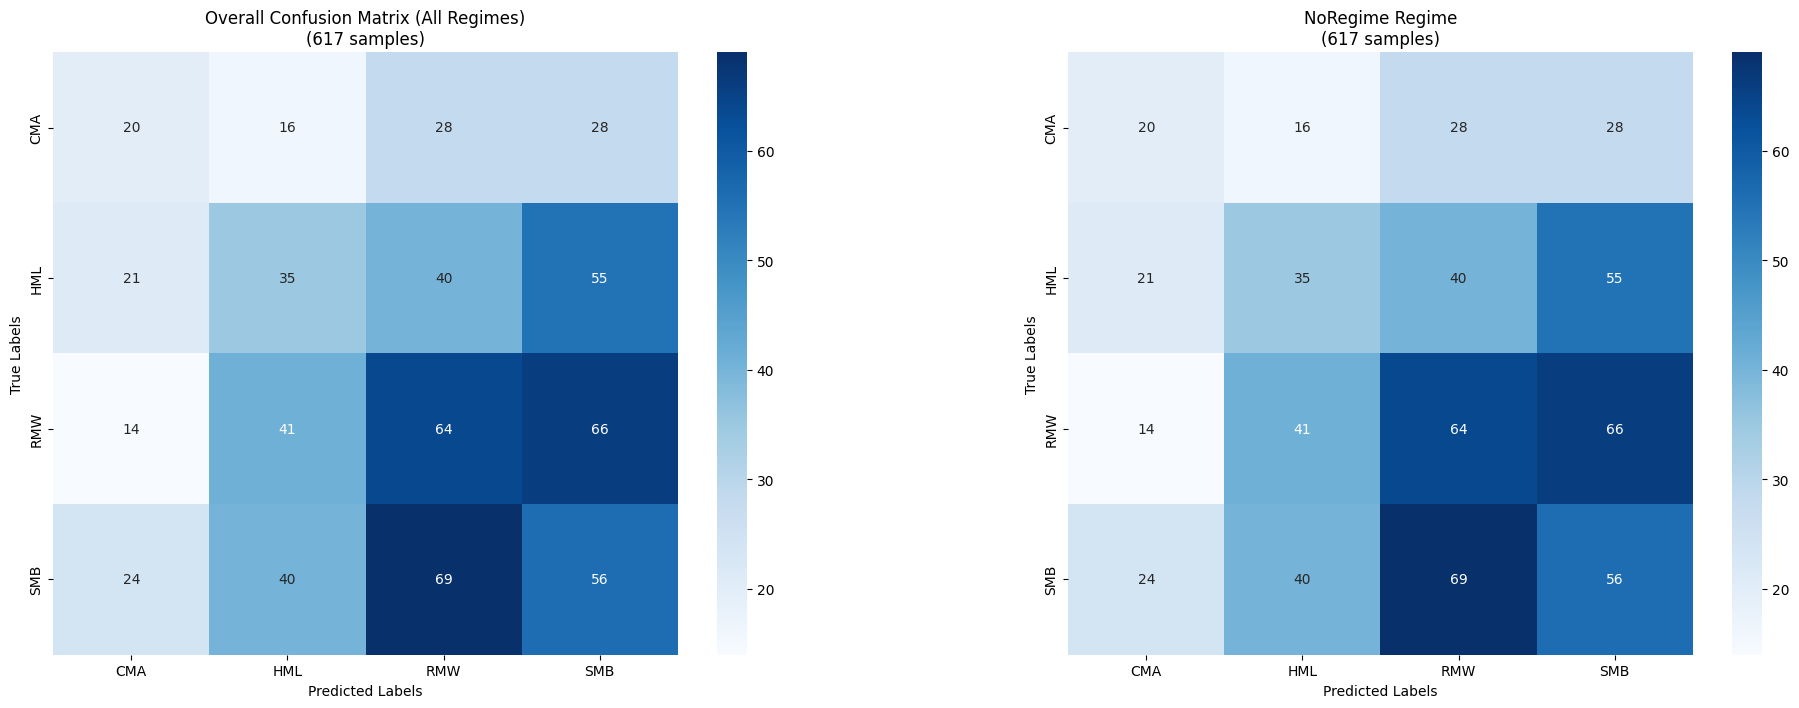

In [152]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get all unique regimes dynamically
all_regimes = results_df['Regime'].unique()

# Prepare labels from winning factors (sorted by their numeric IDs)
labels = [winning_factor_dict[winning_factor_mapping[i]]['short']
          for i in sorted(winning_factor_mapping.keys())]

# Convert to short names for actual/predicted values
all_true = results_df['Actual_Winner'].map(lambda x: factor_rename_mapping.get(x, x))
all_pred = results_df['Predicted_Winner'].map(lambda x: factor_rename_mapping.get(x, x))

# Create a figure with a grid layout for the confusion matrices
# Increase the figsize width by 30% (from 15 to 19.5)
fig, axes = plt.subplots(nrows=1, ncols=len(all_regimes) + 1, figsize=(19.5, 8))

# 1. Overall confusion matrix
cm_total = confusion_matrix(all_true, all_pred, labels=labels)
sns.heatmap(cm_total, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels,
            ax=axes[0])
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("True Labels")

# Calculate the number of samples for the overall matrix
total_samples = len(results_df)
axes[0].set_title(f"Overall Confusion Matrix (All Regimes)\n({total_samples} samples)")

# 2. Per-regime confusion matrices
for i, regime in enumerate(all_regimes):
    # Filter results for current regime
    regime_mask = results_df['Regime'] == regime
    regime_true = all_true[regime_mask]
    regime_pred = all_pred[regime_mask]

    if len(regime_true) == 0:
        print(f"\nNo samples for regime '{regime}'. Skipping confusion matrix.")
        continue

    # Plot the confusion matrix for the regime
    cm = confusion_matrix(regime_true, regime_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels,
                ax=axes[i+1])  # i+1 to place the regime-specific matrix
    axes[i+1].set_xlabel("Predicted Labels")
    axes[i+1].set_ylabel("True Labels")
    axes[i+1].set_title(f"{regime} Regime\n({len(regime_true)} samples)")

# Adjust layout to make space between the subplots
plt.tight_layout(pad=4.0)  # pad=4.0 adds space between subplots

# Adjust the spacing between subplots if needed
plt.subplots_adjust(wspace=0.3)  # Add space between subplots

# Show the plot
plt.show()



<ipython-input-153-d99f00845294>:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=4.0)


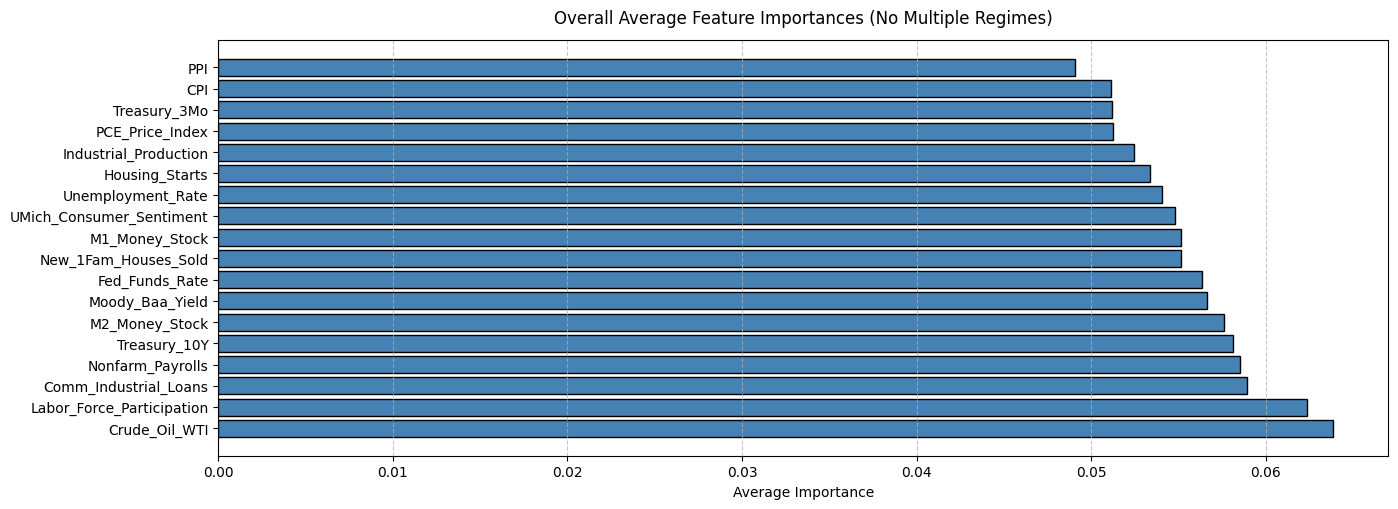

In [153]:
# --- Code cell 26 ---
# 2. Regime-Specific Feature Importances (Dynamic Version)
# ========================================================

import numpy as np
import matplotlib.pyplot as plt

# Get the unique regimes from results_df (already converted to string names)
existing_regimes = results_df['Regime'].unique()
n_regimes = len(existing_regimes)

# Dynamically get the number of features from the data
n_features = len(results_df['Feature_Importances'].iloc[0])  # Actual feature count

# Robust feature name handling:
try:
    # Validate FEATURES list length matches actual features
    if len(FEATURES) != n_features:
        print(f"⚠️ Warning: FEATURES list length ({len(FEATURES)}) doesn't match model features ({n_features})")
        print("Using auto-generated feature names instead")
        raise ValueError
    feature_names = FEATURES
except (NameError, ValueError):
    # Generate descriptive feature names if there's a mismatch or error
    feature_names = [f'Feature {i+1}' for i in range(n_features)]
    print(f"Using auto-generated feature names for {n_features} features")

# Compute overall average feature importances across all predictions
overall_avg_fi = np.vstack(results_df['Feature_Importances'].values).mean(axis=0)

# Calculate regime-specific average feature importances
regime_avg_fi = {}
for regime_name in existing_regimes:
    regime_df = results_df[results_df['Regime'] == regime_name]
    regime_fi_array = np.vstack(regime_df['Feature_Importances'].values)
    regime_avg_fi[regime_name] = regime_fi_array.mean(axis=0)

# Sort features by overall importance in descending order
sorted_idx = overall_avg_fi.argsort()[::-1]
sorted_idx = sorted_idx[sorted_idx < len(feature_names)]  # bounds check
sorted_features = [feature_names[i] for i in sorted_idx]

# 1) If we have more than one unique regime, make an overall + multiple regime subplots
if n_regimes > 1:
    total_plots = 1 + n_regimes  # One for overall, one per regime
    # Figure height depends on number of plots and number of features
    row_height = max(0.3 * n_features, 4)
    fig, axs = plt.subplots(
        total_plots,
        1,
        figsize=(19.5, total_plots * row_height),
        gridspec_kw={'hspace': 0.4}
    )
    if total_plots == 1:
        axs = [axs]  # ensure iterable

    # --- Overall Feature Importances ---
    axs[0].barh(
        np.arange(n_features),
        overall_avg_fi[sorted_idx],
        color='steelblue',
        edgecolor='black'
    )
    axs[0].set_yticks(np.arange(n_features))
    axs[0].set_yticklabels(sorted_features)
    axs[0].set_title("Overall Average Feature Importances", pad=12)
    axs[0].set_xlabel("Average Importance")
    axs[0].grid(axis='x', linestyle='--', alpha=0.7)

    # --- Regime-Specific Plots ---
    for idx, (regime_name, avg_fi) in enumerate(regime_avg_fi.items(), start=1):
        sorted_regime_fi = avg_fi[sorted_idx]
        axs[idx].barh(
            np.arange(n_features),
            sorted_regime_fi,
            color='salmon',
            edgecolor='black'
        )
        axs[idx].set_yticks(np.arange(n_features))
        axs[idx].set_yticklabels(sorted_features)
        axs[idx].set_title(f"Feature Importances: {regime_name} Regime", pad=12)
        axs[idx].set_xlabel("Average Importance")
        axs[idx].grid(axis='x', linestyle='--', alpha=0.7)

# 2) Otherwise, if there's only zero or one regime, show only the overall chart
else:
    total_plots = 1
    row_height = max(0.3 * n_features, 4)
    fig, ax = plt.subplots(
        1, 1, figsize=(19.5, row_height),
        gridspec_kw={'hspace': 0.4}
    )

    # --- Overall Feature Importances ---
    ax.barh(
        np.arange(n_features),
        overall_avg_fi[sorted_idx],
        color='steelblue',
        edgecolor='black'
    )
    ax.set_yticks(np.arange(n_features))
    ax.set_yticklabels(sorted_features)
    ax.set_title("Overall Average Feature Importances (No Multiple Regimes)", pad=12)
    ax.set_xlabel("Average Importance")
    ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout(pad=4.0)
plt.subplots_adjust(left=0.3)  # Provide extra space on the left for feature labels
plt.show()


Date Range: 1973-07-31 00:00:00 to 2024-11-30 00:00:00


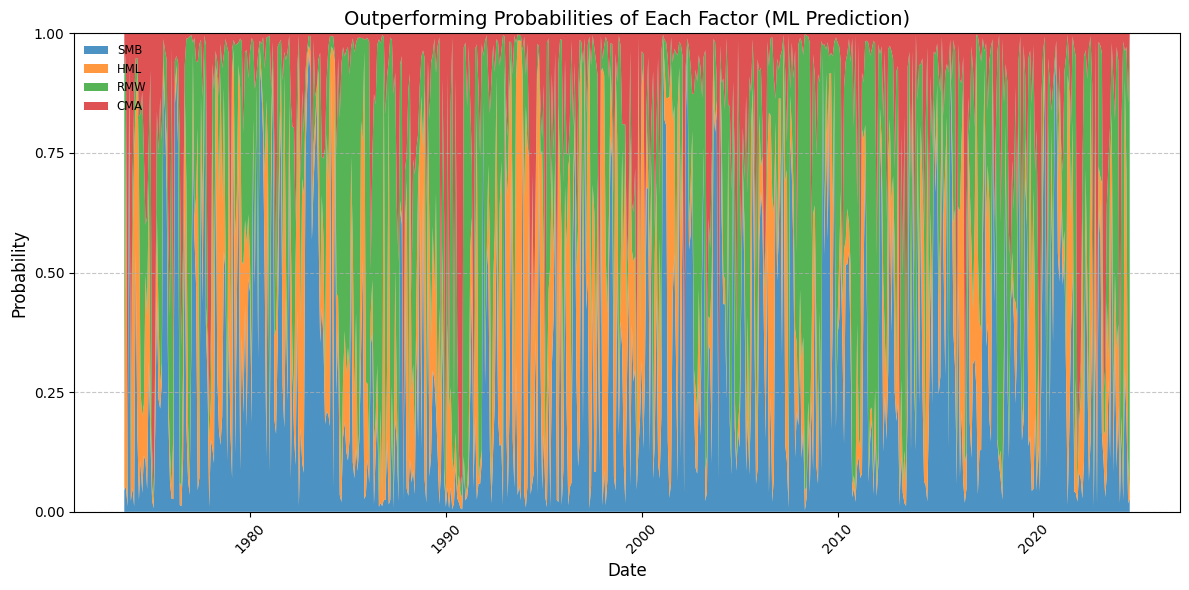

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Convert "Predicted_month" to datetime (assuming the format is '%Y-%m'):
probability_dates = pd.to_datetime(
    results_df["Predicted_month"],
    format='%Y-%m'
)

# 2) Drop rows with unparseable dates if needed
if probability_dates.isna().any():
    print("Warning: Some dates could not be parsed. Dropping those rows.")
    results_df = results_df.loc[~probability_dates.isna()].copy()
    probability_dates = probability_dates.dropna()

# 3) Extract the probability arrays and build a DataFrame
full_probs = np.vstack(results_df["Predicted_Probabilities"].values)
probability_df = pd.DataFrame(full_probs, columns=FACTORS)
probability_df["Date"] = probability_dates
probability_df = probability_df.sort_values("Date").reset_index(drop=True)

# 4) Check date range
print("Date Range:", probability_df["Date"].min(), "to", probability_df["Date"].max())

# 5) Plot the probabilities in a stack plot
plt.figure(figsize=(12, 6))
plt.stackplot(
    probability_df["Date"],
    [probability_df[col] for col in FACTORS],
    labels=FACTORS,
    alpha=0.8
)

plt.title("Outperforming Probabilities of Each Factor (ML Prediction)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Probability", fontsize=12)

# Manually set y-axis ticks at 0, 0.25, 0.5, 0.75, 1
plt.ylim(0, 1)
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

plt.legend(loc='upper left', fontsize='small', frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

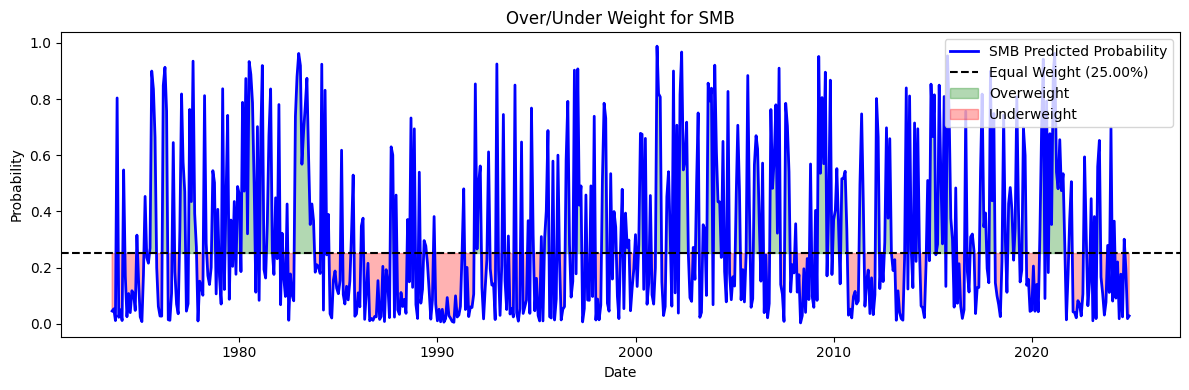

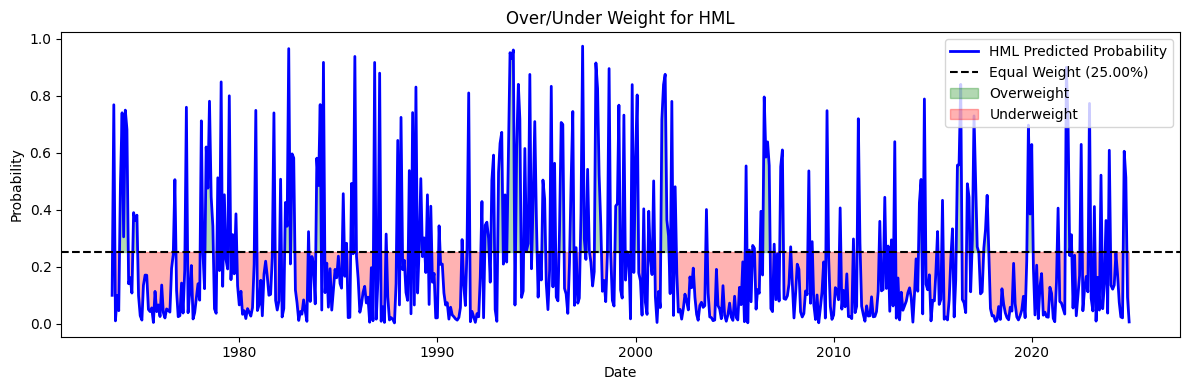

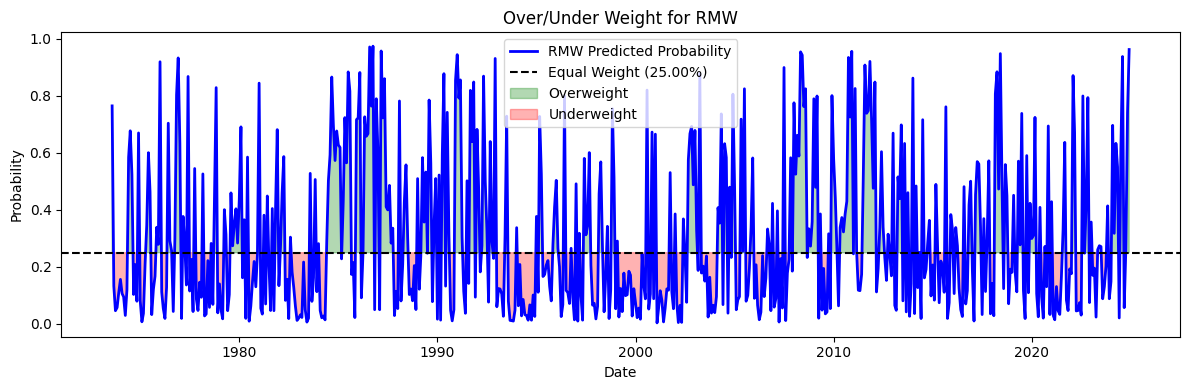

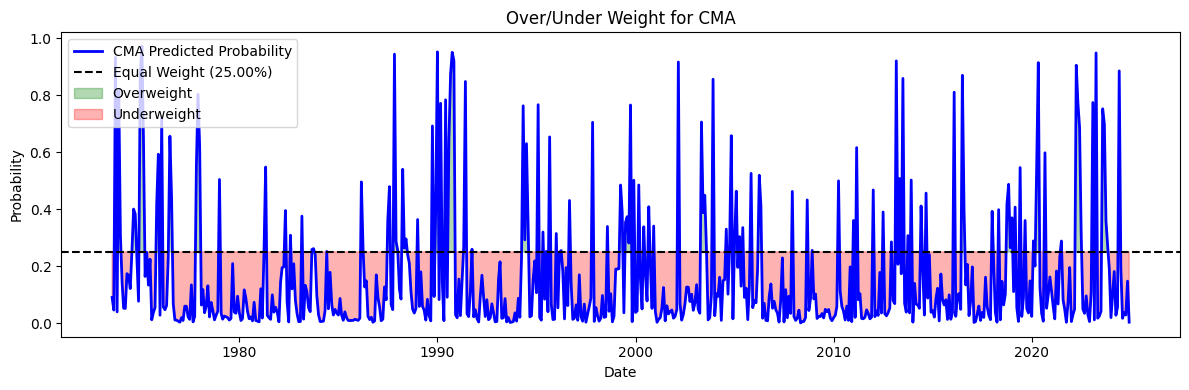

In [155]:
# --- Extra Code Cell: Over/Under Weight Comparison for Each Factor ---

# Define the equal weight value (static equal weight for each factor)
equal_weight = 1 / len(FACTORS)  # For example, if 5 factors then equal_weight = 0.20

import matplotlib.pyplot as plt

# Loop over each factor in FACTORS and create a separate chart
for factor in FACTORS:
    plt.figure(figsize=(12, 4))

    # Plot the predicted probability for the current factor
    plt.plot(probability_df["Date"], probability_df[factor],
             label=f"{factor} Predicted Probability", color='blue', linewidth=2)

    # Plot the static equal weight line
    plt.axhline(equal_weight, color='black', linestyle='--',
                label=f"Equal Weight ({equal_weight:.2%})")

    # Shade the area where the predicted probability is above the equal weight (Overweight)
    plt.fill_between(probability_df["Date"],
                     probability_df[factor],
                     equal_weight,
                     where=(probability_df[factor] > equal_weight),
                     interpolate=True, color='green', alpha=0.3, label='Overweight')

    # Shade the area where the predicted probability is below the equal weight (Underweight)
    plt.fill_between(probability_df["Date"],
                     probability_df[factor],
                     equal_weight,
                     where=(probability_df[factor] < equal_weight),
                     interpolate=True, color='red', alpha=0.3, label='Underweight')

    # Set chart title and labels
    plt.title(f"Over/Under Weight for {factor}")
    plt.xlabel("Date")
    plt.ylabel("Probability")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

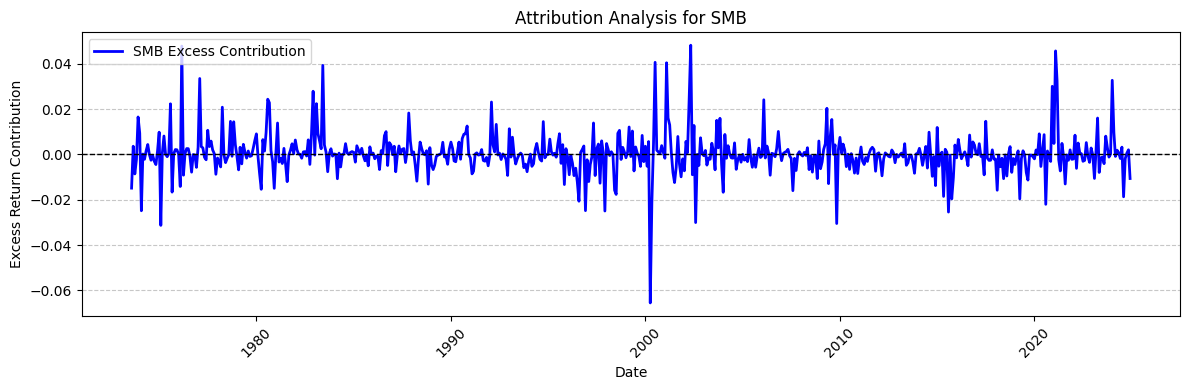

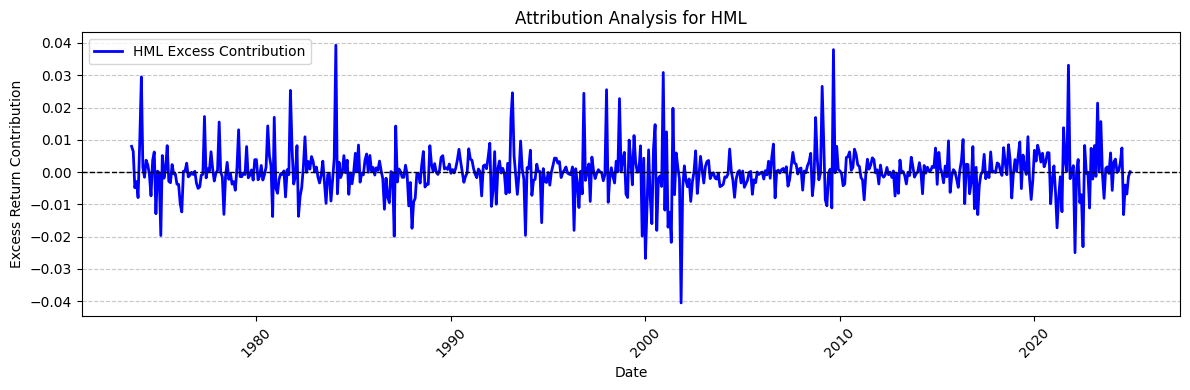

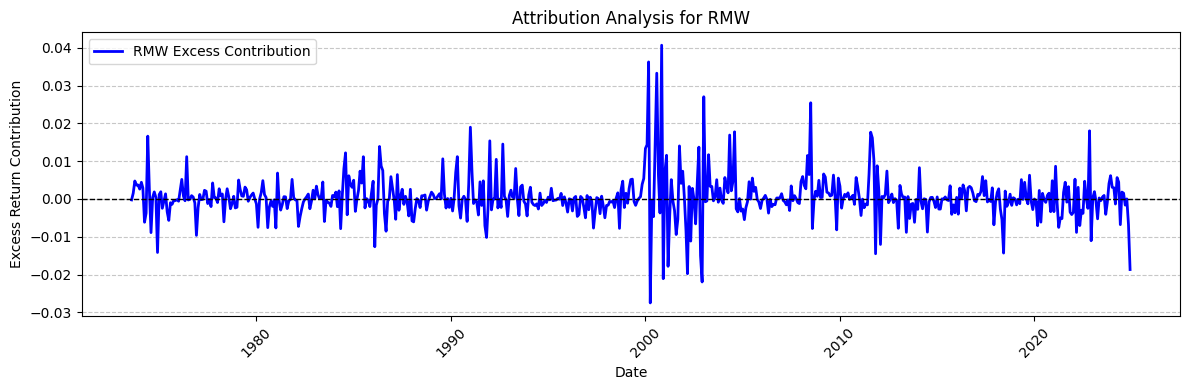

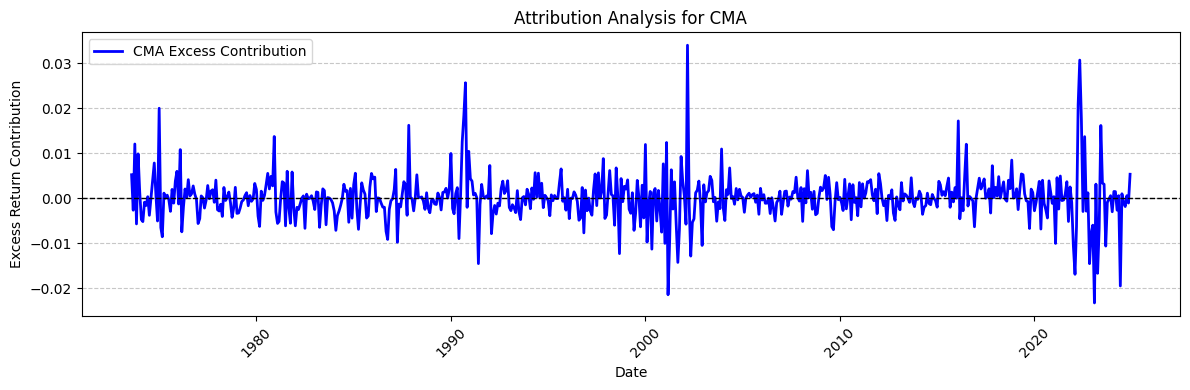

In [156]:
# --- Extra Code Cell: Separate Attribution Analysis Charts for Each Factor ---

# Merge the predicted probabilities with factor returns.
# We use suffixes to distinguish between probability and return columns.
attribution_df = pd.merge(
    probability_df,
    merged_df,
    left_on="Date",
    right_on="Predicted_month",
    suffixes=('_prob', '_return')
)

# Define the static equal weight (1 divided by the number of factors)
equal_weight = 1 / len(FACTORS)  # e.g., if 5 factors, equal_weight = 0.20

# Loop over each factor to compute its excess contribution and generate a chart.
for factor in FACTORS:
    # Calculate the excess contribution for this factor:
    # (predicted probability - equal weight) * factor return.
    attribution_df[f'{factor}_excess'] = (attribution_df[f'{factor}_prob'] - equal_weight) * attribution_df[f'{factor}_return']

    # Plot the excess contribution over time.
    plt.figure(figsize=(12, 4))
    plt.plot(attribution_df['Date'], attribution_df[f'{factor}_excess'], label=f'{factor} Excess Contribution', color='blue', linewidth=2)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Baseline for zero excess
    plt.xlabel("Date")
    plt.ylabel("Excess Return Contribution")
    plt.title(f"Attribution Analysis for {factor}")
    plt.legend(loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

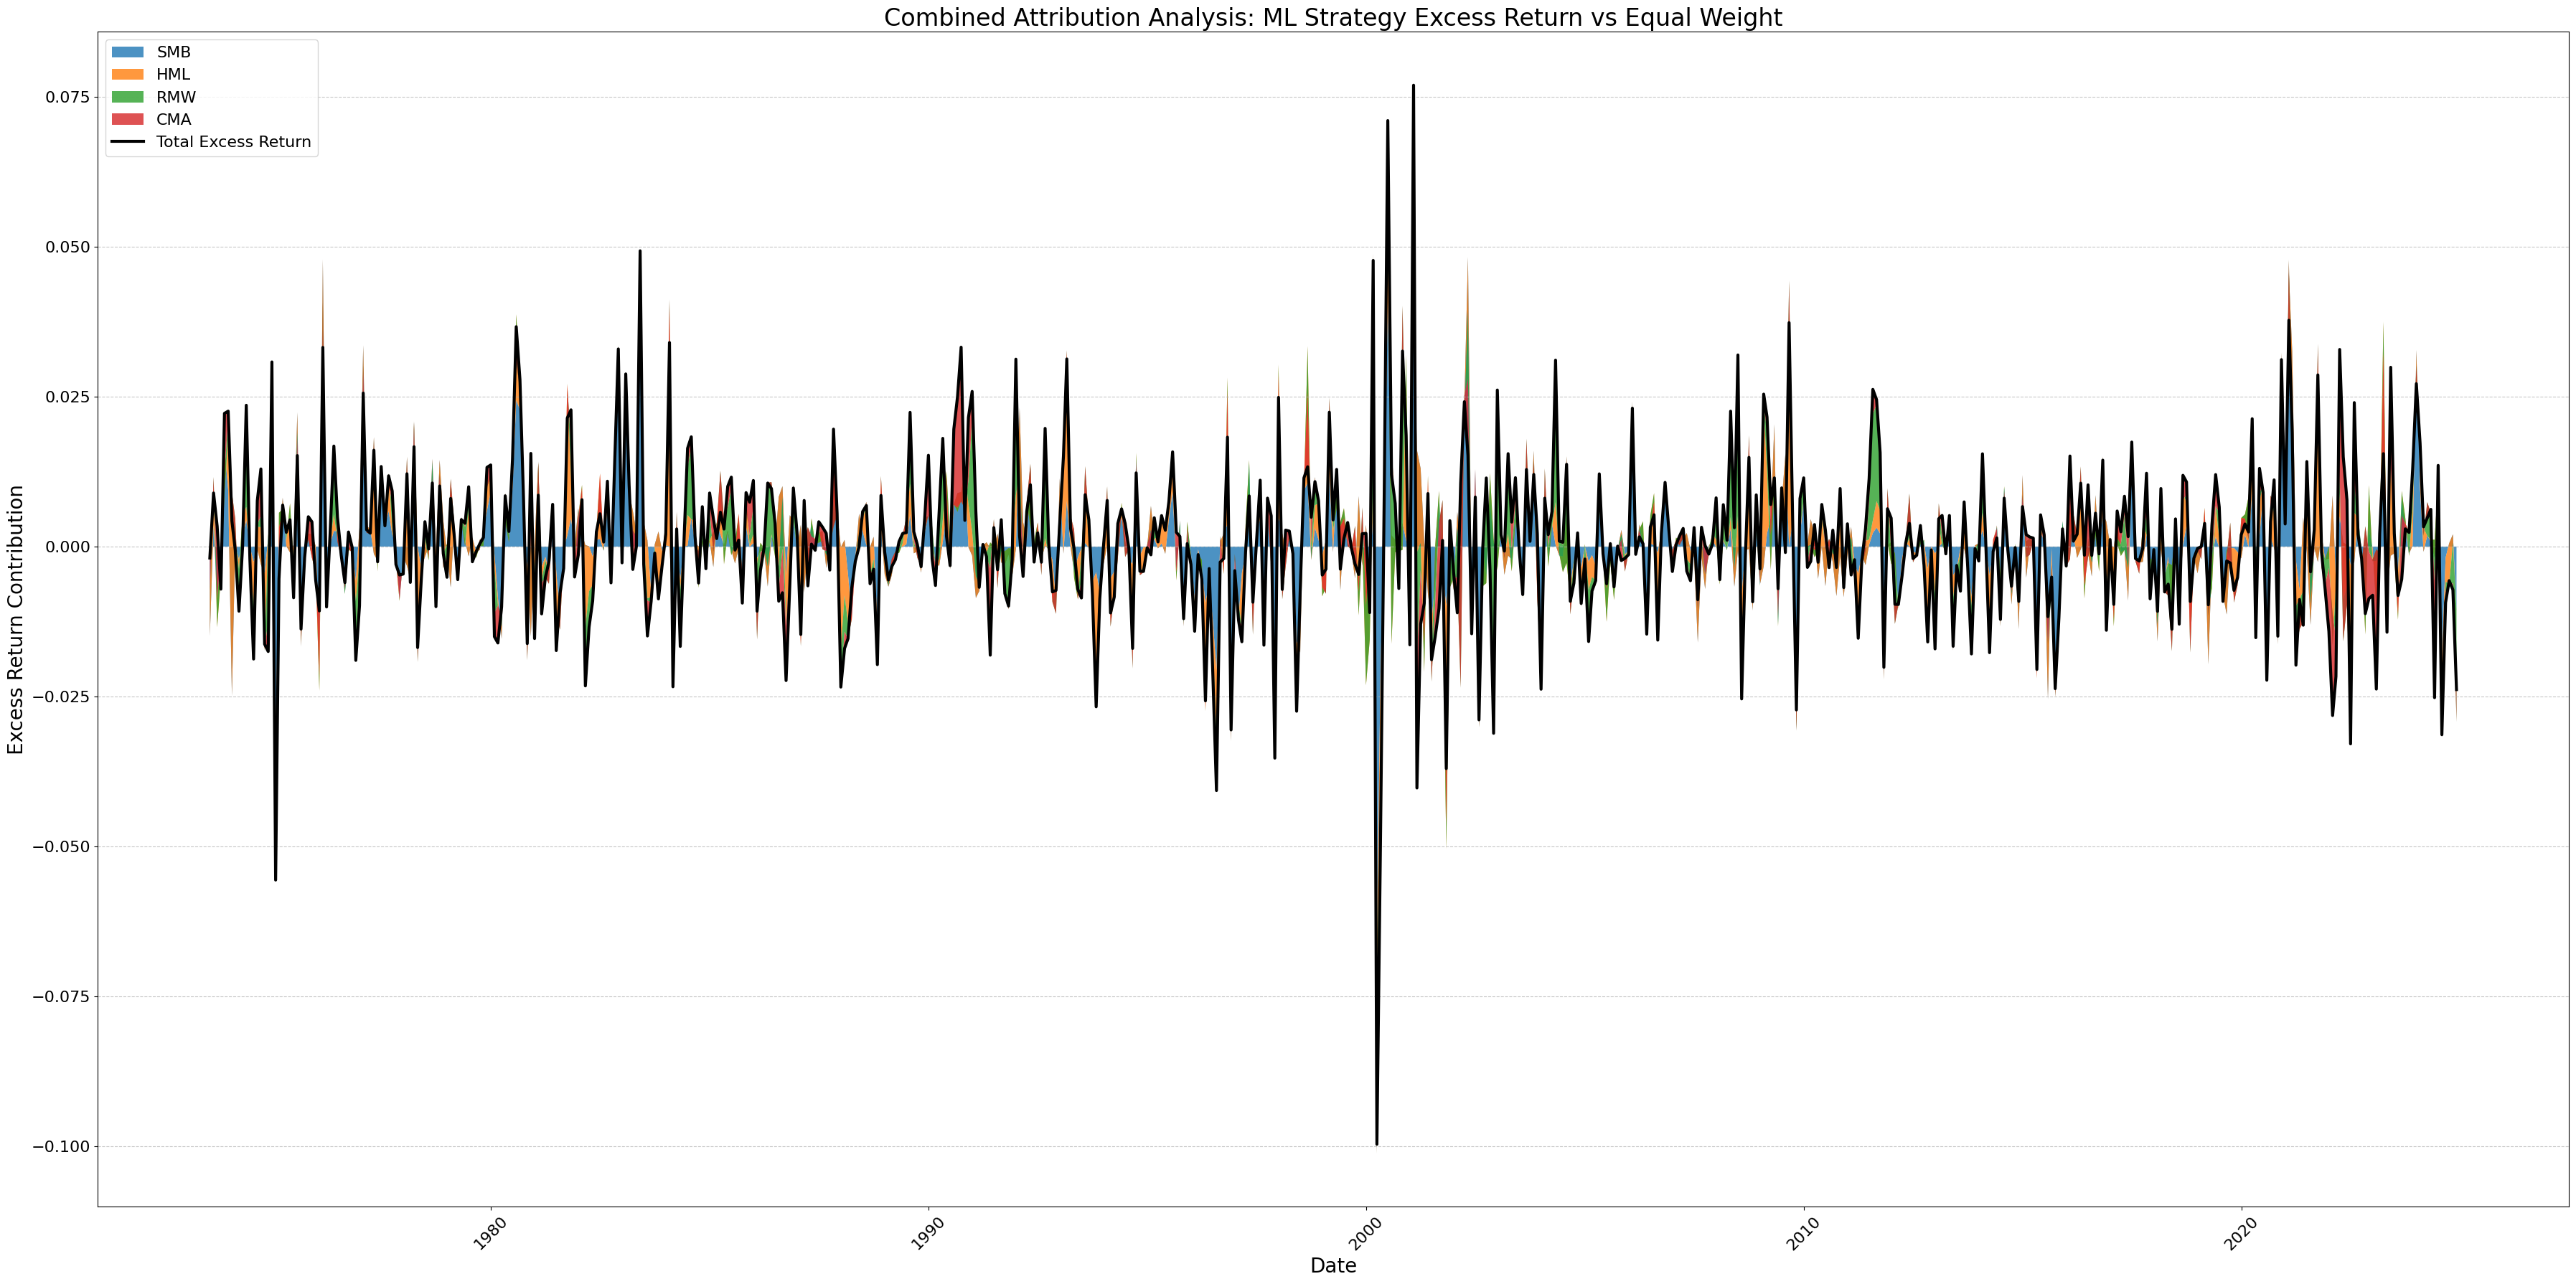

In [157]:
# --- Extra Code Cell: Combined Attribution Analysis Chart (3x Bigger) ---
# Merge the predicted probabilities (from probability_df) with factor returns (from merged_df)
attribution_df = pd.merge(
    probability_df,
    merged_df,
    left_on="Date",
    right_on="Predicted_month",
    suffixes=('_prob', '_return')
)

# Define the static equal weight (1 divided by the number of factors)
equal_weight = 1 / len(FACTORS)  # For example, if 5 factors then equal_weight = 0.20

# Calculate each factor's excess contribution
for factor in FACTORS:
    attribution_df[f'{factor}_excess'] = (attribution_df[f'{factor}_prob'] - equal_weight) * attribution_df[f'{factor}_return']

# Compute the total excess return as the sum of individual factor contributions.
excess_cols = [f'{factor}_excess' for factor in FACTORS]
attribution_df['total_excess'] = attribution_df[excess_cols].sum(axis=1)

# Create a combined chart: a stacked area chart for each factor's contribution with an overlay for total excess return.
plt.figure(figsize=(36, 18))  # 3x bigger than the original 12x6 size
dates = attribution_df["Date"]

# Prepare the data for stacking: a list of each factor's excess contribution over time.
stack_data = [attribution_df[f'{factor}_excess'].values for factor in FACTORS]

# Plot the stacked area chart.
plt.stackplot(dates, *stack_data, labels=FACTORS, alpha=0.8)

# Overlay a line for the total excess return.
plt.plot(dates, attribution_df['total_excess'], color='black', linewidth=3, label='Total Excess Return')

plt.xlabel("Date", fontsize=20)
plt.ylabel("Excess Return Contribution", fontsize=20)
plt.title("Combined Attribution Analysis: ML Strategy Excess Return vs Equal Weight", fontsize=24)
plt.legend(loc='upper left', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

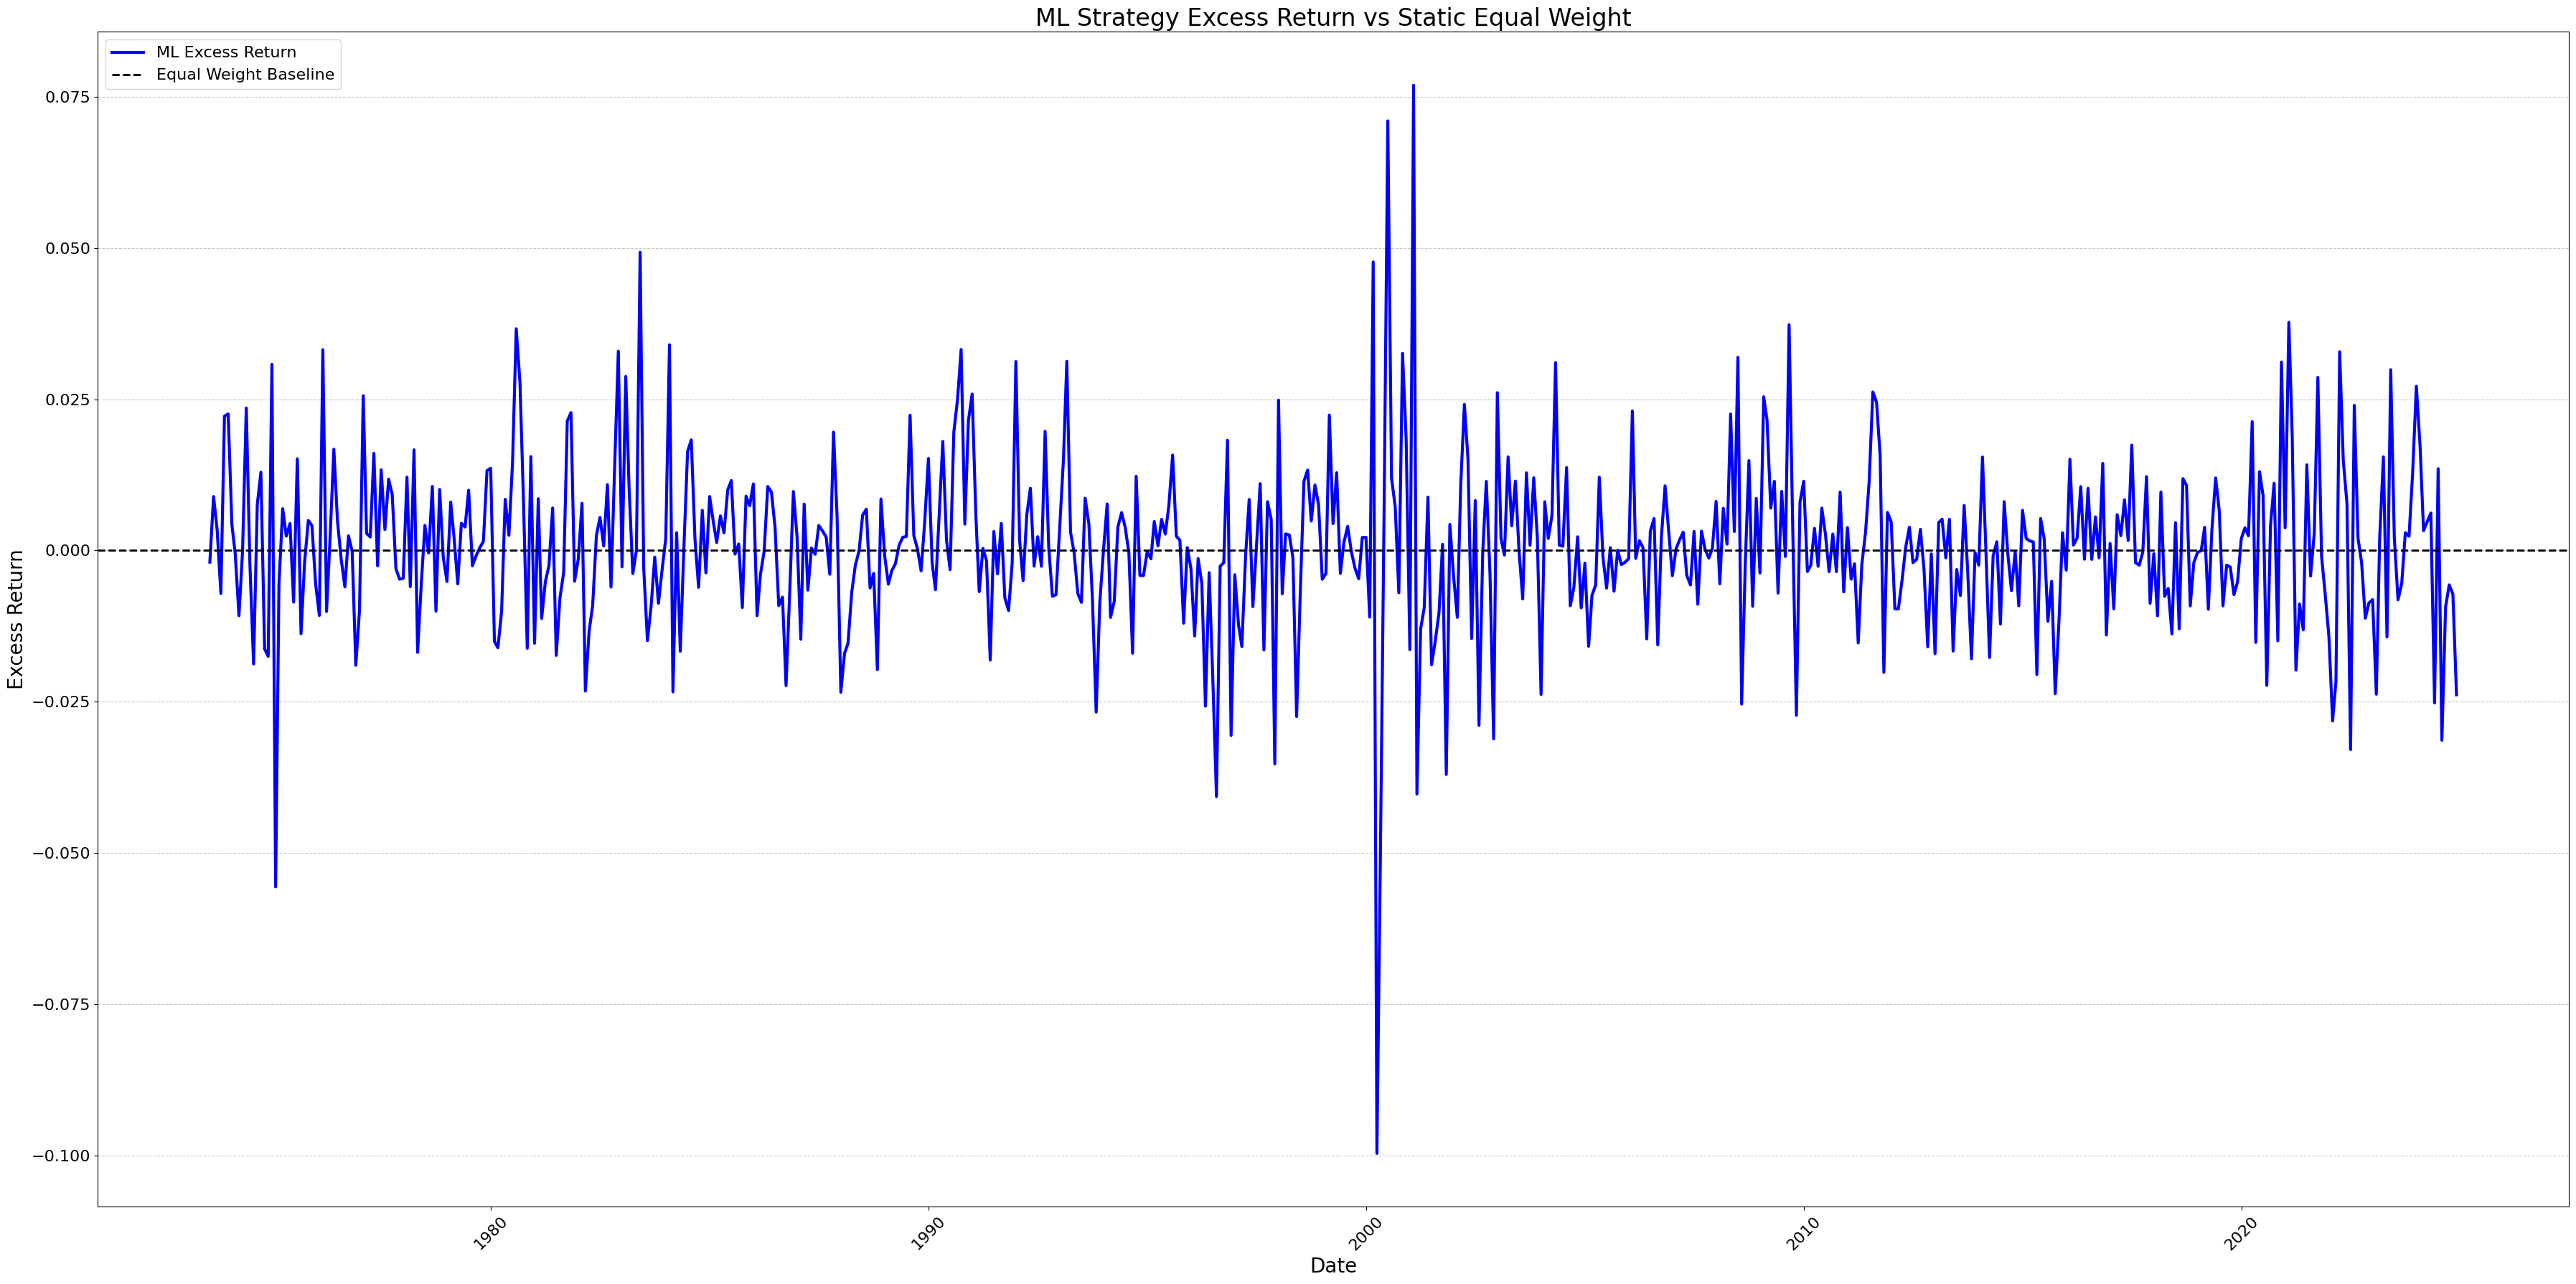

In [159]:
# --- Extra Code Cell: Combined ML Strategy Excess Return (Blue Line Chart) ---

# Merge the predicted probabilities (from probability_df) with factor returns (from merged_df)
attribution_df = pd.merge(
    probability_df,
    merged_df,
    left_on="Date",
    right_on="Predicted_month",
    suffixes=('_prob', '_return')
)

# Define the static equal weight (1 divided by the number of factors)
equal_weight = 1 / len(FACTORS)  # e.g., for 5 factors, equal_weight = 0.20

# Compute each factor's excess contribution and then sum them to get the total excess return
excess_cols = []
for factor in FACTORS:
    col_name = f'{factor}_excess'
    attribution_df[col_name] = (attribution_df[f'{factor}_prob'] - equal_weight) * attribution_df[f'{factor}_return']
    excess_cols.append(col_name)

attribution_df['total_excess'] = attribution_df[excess_cols].sum(axis=1)

# Plot the total excess return as a blue line chart
plt.figure(figsize=(36, 18))  # 3x bigger than original (36x18 inches)
plt.plot(attribution_df["Date"], attribution_df['total_excess'], color='blue', linewidth=3, label='ML Excess Return')
plt.axhline(0, color='black', linestyle='--', linewidth=2, label='Equal Weight Baseline')

plt.xlabel("Date", fontsize=20)
plt.ylabel("Excess Return", fontsize=20)
plt.title("ML Strategy Excess Return vs Static Equal Weight", fontsize=24)
plt.legend(loc='upper left', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

In [160]:
import pandas as pd

# Assume probability_df is your DataFrame with a Date column and the factor probability columns:
# For example, columns: 'Date', 'SMB', 'HML', 'RMW', 'CMA'

# Compute the average probability for each factor over all time.
avg_probs = probability_df[['SMB', 'HML', 'RMW', 'CMA']].mean()

# Convert the Series to a DataFrame for clearer display:
avg_probs_df = avg_probs.reset_index()
avg_probs_df.columns = ['Factor', 'Average Probability']

print("Average Outperforming Probabilities Over Time:")
print(avg_probs_df)

Average Outperforming Probabilities Over Time:
  Factor  Average Probability
0    SMB             0.307653
1    HML             0.221977
2    RMW             0.308531
3    CMA             0.161840


### **Backtesting & statistics**

In [161]:
# Ensure the 'Predicted_month' column is in datetime format
results_df['Predicted_month'] = pd.to_datetime(results_df['Predicted_month'])

# Get the earliest date from the 'Predicted_month' column
first_date = results_df['Predicted_month'].min()
last_date = results_df['Predicted_month'].max()

print("First date Predicted_month column in results_df:", first_date)
print("Last date in Predicted_month column results_df:", last_date)

First date Predicted_month column in results_df: 1973-07-31 00:00:00
Last date in Predicted_month column results_df: 2024-11-30 00:00:00


In [162]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# --- Part 1: Process results_df ---

# Ensure 'Predicted_month' is in datetime format
results_df['Predicted_month'] = pd.to_datetime(results_df['Predicted_month'])

# Define your dynamic date range (adjust as needed)
start_date = pd.to_datetime('1973-07-31')
end_date   = pd.to_datetime('2024-11-30')

# Filter results_df for the date range and select the desired columns
filtered_df = results_df.loc[
    (results_df['Predicted_month'] >= start_date) & (results_df['Predicted_month'] <= end_date),
    ['Predicted_month', 'Allocated_Return']
].sort_values('Predicted_month')

# Rename 'Allocated_Return' to 'ML Allocated Strategy Return'
filtered_df = filtered_df.rename(columns={'Allocated_Return': 'ML Allocated Strategy Return'})

# Calculate cumulative returns for the ML allocated strategy using compound returns (wealth index starting at 1)
filtered_df['ML Cumulative Allocated Return'] = (1 + filtered_df['ML Allocated Strategy Return']).cumprod()


# --- Part 2: Process the second DataFrame (df) without modifying it ---

# Create a filtered copy of df for the same date range using the 'Date' column.
df_filtered = df.loc[
    (pd.to_datetime(df['Date']) >= start_date) & (pd.to_datetime(df['Date']) <= end_date)
].copy()

# Ensure the 'Date' column is datetime for correct sorting and merging
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

# Sort by 'Date'
df_filtered = df_filtered.sort_values('Date')

# Calculate cumulative returns for the benchmark column using 'Mkt-Rf'
df_filtered['Benchmark Cumulative Returns'] = (1 + df_filtered['Mkt-RF']).cumprod()

# Calculate the Equal Factor Weight Strategy returns by taking an equal-weight average of 4 factors (excluding MOM)
df_filtered['Equal Factor Weight Strategy'] = (
    df_filtered['SMB'] +
    df_filtered['HML'] +
    df_filtered['RMW'] +
    df_filtered['CMA']
) / 4

# Calculate cumulative returns for the Equal Factor Weight Strategy using compound returns (wealth index starting at 1)
df_filtered['Equal Factor Weight Cumulative Return'] = (1 + df_filtered['Equal Factor Weight Strategy']).cumprod()


# --- Part 3: Merge the two DataFrames ---

# Merge the filtered DataFrames on their date columns:
#   - In filtered_df: 'Predicted_month' (as datetime)
#   - In df_filtered: 'Date'
merged_df = pd.merge(
    filtered_df,
    df_filtered[['Date', 'Benchmark Cumulative Returns', 'Equal Factor Weight Strategy', 'Equal Factor Weight Cumulative Return']],
    left_on='Predicted_month',
    right_on='Date',
    how='left'
)

# Drop the duplicate 'Date' column from the merge
merged_df.drop(columns=['Date'], inplace=True)

# Display the final merged DataFrame
print(merged_df)

    Predicted_month  ML Allocated Strategy Return  \
0        1973-07-31                     -0.005364   
1        1973-08-31                      0.007398   
2        1973-09-30                      0.016017   
3        1973-10-31                     -0.001169   
4        1973-11-30                      0.011425   
..              ...                           ...   
612      2024-07-31                      0.005321   
613      2024-08-31                     -0.017013   
614      2024-09-30                     -0.015249   
615      2024-10-31                     -0.008049   
616      2024-11-30                     -0.023988   

     ML Cumulative Allocated Return  Benchmark Cumulative Returns  \
0                          0.994636                      1.050500   
1                          1.001994                      1.010371   
2                          1.018042                      1.058364   
3                          1.016852                      1.049579   
4                 

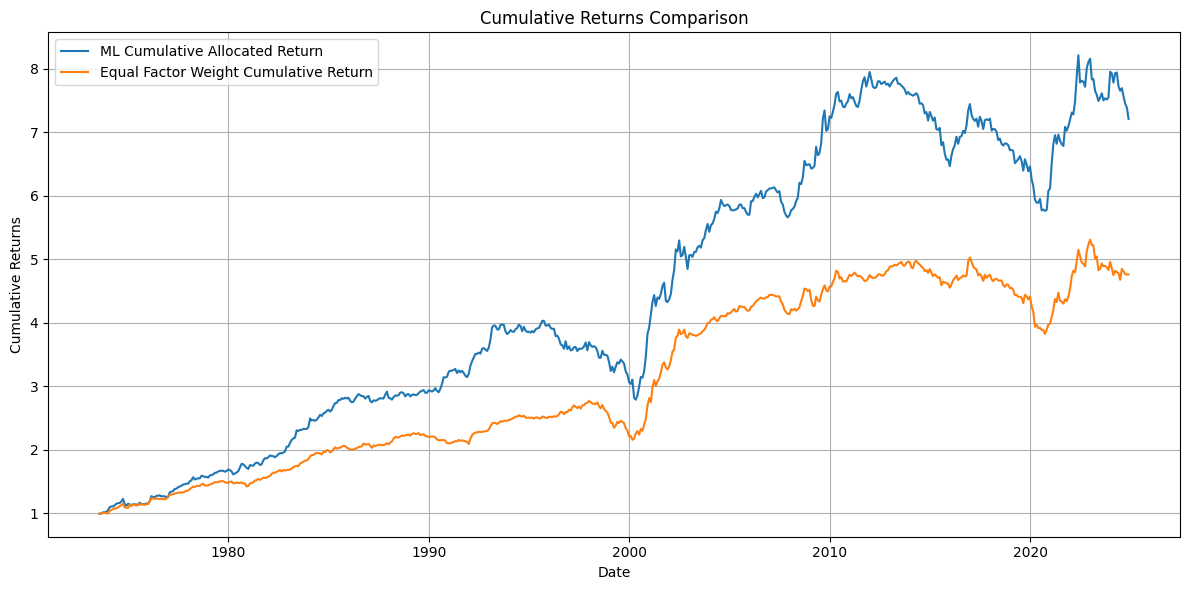

In [163]:
import matplotlib.pyplot as plt

# Ensure the DataFrame is sorted by Predicted_month
merged_df = merged_df.sort_values('Predicted_month')

plt.figure(figsize=(12, 6))

# Plot the ML Cumulative Allocated Return without markers
plt.plot(
    merged_df['Predicted_month'],
    merged_df['ML Cumulative Allocated Return'],
    label='ML Cumulative Allocated Return'
)

# Plot the Equal Factor Weight Cumulative Return without markers
plt.plot(
    merged_df['Predicted_month'],
    merged_df['Equal Factor Weight Cumulative Return'],
    label='Equal Factor Weight Cumulative Return'
)



plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [164]:
import numpy as np
import pandas as pd

# --- PERFORMANCE METRICS ---

# For the ML Allocated Strategy:
ml_returns = merged_df['ML Allocated Strategy Return']
ml_mean_monthly = ml_returns.mean()
ml_std_monthly  = ml_returns.std()
ml_annualized_return = ml_mean_monthly * 12
ml_annualized_vol    = ml_std_monthly * np.sqrt(12)
ml_sharpe            = ml_annualized_return / ml_annualized_vol

# For the Equal Factor Weight Strategy:
equal_returns = merged_df['Equal Factor Weight Strategy']
equal_mean_monthly = equal_returns.mean()
equal_std_monthly  = equal_returns.std()
equal_annualized_return = equal_mean_monthly * 12
equal_annualized_vol    = equal_std_monthly * np.sqrt(12)
equal_sharpe            = equal_annualized_return / equal_annualized_vol

# --- PRINT PERFORMANCE METRICS ---
print("\nPERFORMANCE METRICS:\n")

print("ML Allocated Strategy:")
print(f"  Annualized Return:      {ml_annualized_return:.2%}")
print(f"  Annualized Volatility:  {ml_annualized_vol:.2%}")
print(f"  Sharpe Ratio:           {ml_sharpe:.2f}\n")

print("Equal Factor Weight Strategy:")
print(f"  Annualized Return:      {equal_annualized_return:.2%}")
print(f"  Annualized Volatility:  {equal_annualized_vol:.2%}")
print(f"  Sharpe Ratio:           {equal_sharpe:.2f}\n")


# --- MAXIMUM DRAWDOWN CALCULATIONS ---
# Compute wealth indexes starting at 1 for each strategy.
wealth_ml = (1 + merged_df['ML Allocated Strategy Return']).cumprod()
wealth_equal = (1 + merged_df['Equal Factor Weight Strategy']).cumprod()

# Compute drawdown series for each strategy:
drawdown_ml = wealth_ml / wealth_ml.cummax() - 1
drawdown_equal = wealth_equal / wealth_equal.cummax() - 1

# Maximum drawdown is the minimum value in the drawdown series.
max_dd_ml = drawdown_ml.min()
max_dd_equal = drawdown_equal.min()

print("MAXIMUM DRAWDOWNS:\n")
print("ML Allocated Strategy Max Drawdown:       ", f"{max_dd_ml:.2%}")
print("Equal Factor Weight Strategy Max Drawdown:  ", f"{max_dd_equal:.2%}")


PERFORMANCE METRICS:

ML Allocated Strategy:
  Annualized Return:      4.07%
  Annualized Volatility:  6.61%
  Sharpe Ratio:           0.61

Equal Factor Weight Strategy:
  Annualized Return:      3.17%
  Annualized Volatility:  5.12%
  Sharpe Ratio:           0.62

MAXIMUM DRAWDOWNS:

ML Allocated Strategy Max Drawdown:        -30.78%
Equal Factor Weight Strategy Max Drawdown:   -23.93%


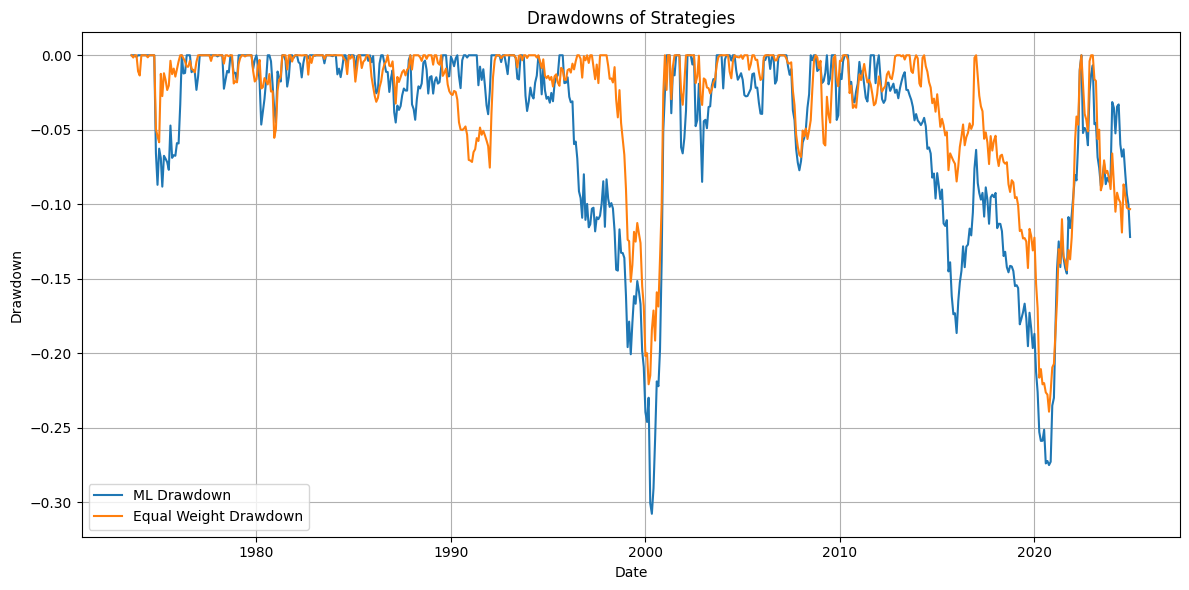

In [165]:
import matplotlib.pyplot as plt

# --- Compute Drawdowns for Each Strategy ---

# ML Allocated Strategy Drawdown
merged_df['ML Drawdown'] = merged_df['ML Cumulative Allocated Return'] / merged_df['ML Cumulative Allocated Return'].cummax() - 1

# Benchmark Drawdown (using Mkt-RF) – remains commented out (if desired)
# merged_df['Benchmark Drawdown'] = merged_df['Benchmark Cumulative Returns'] / merged_df['Benchmark Cumulative Returns'].cummax() - 1

# Equal Factor Weight Strategy Drawdown
merged_df['Equal Weight Drawdown'] = merged_df['Equal Factor Weight Cumulative Return'] / merged_df['Equal Factor Weight Cumulative Return'].cummax() - 1

# --- Plot the Drawdowns ---
plt.figure(figsize=(12, 6))

plt.plot(merged_df['Predicted_month'], merged_df['ML Drawdown'], label='ML Drawdown')
# plt.plot(merged_df['Predicted_month'], merged_df['Benchmark Drawdown'], label='Benchmark Drawdown')
plt.plot(merged_df['Predicted_month'], merged_df['Equal Weight Drawdown'], label='Equal Weight Drawdown')

plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.title('Drawdowns of Strategies')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [166]:
import statsmodels.api as sm
import pandas as pd

# --- Step 0: Verify Required Columns in df ---
required_cols = ['Date', 'SMB', 'HML', 'RMW', 'CMA', 'Mkt-RF']
missing = [col for col in required_cols if col not in df.columns]
if missing:
    raise KeyError(f"Missing columns in df: {missing}")

# --- Step 1: Merge the Additional Factor Columns into merged_df ---
# merged_df should already have 'Predicted_month' as datetime.
merged_df = merged_df.merge(
    df[required_cols],
    left_on='Predicted_month',
    right_on='Date',
    how='left',
    suffixes=('', '_new')  # in case some columns already exist in merged_df
)

# For each factor column, if a duplicate appears (with suffix '_new'), use it.
for col in ['SMB', 'HML', 'RMW', 'CMA', 'Mkt-RF']:
    new_col = col + '_new'
    if new_col in merged_df.columns:
        merged_df[col] = merged_df[new_col]
        merged_df.drop(columns=[new_col], inplace=True)

# Drop the duplicate 'Date' column from the merge.
merged_df.drop(columns=['Date'], inplace=True)

# --- Step 2: Multi-Factor Regression for the ML Allocated Strategy ---
# Use 'Mkt-RF' in place of the previous market return factor.
X_ml = merged_df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
X_ml = sm.add_constant(X_ml)  # Add the intercept term
y_ml = merged_df['ML Allocated Strategy Return']  # Dependent variable (excess returns)

# Run the multi-factor OLS regression for the ML strategy.
model_ml = sm.OLS(y_ml, X_ml).fit()

print("Regression Results: ML Allocated Strategy vs FF Factors")
print(model_ml.summary())

# --- Step 3: Multi-Factor Regression for the Equal Factor Weight Strategy ---
X_eq = merged_df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
X_eq = sm.add_constant(X_eq)
y_eq = merged_df['Equal Factor Weight Strategy']  # Dependent variable (excess returns)

model_eq = sm.OLS(y_eq, X_eq).fit()

print("\nRegression Results: Equal Factor Weight Strategy vs FF Factors")
print(model_eq.summary())

# --- Step 4: Annualize the Alpha and Report t-Statistic and p-Value ---
# For the ML Allocated Strategy:
alpha_ml = model_ml.params['const']            # monthly alpha
annualized_alpha_ml = alpha_ml * 12              # simple annualization
t_alpha_ml = model_ml.tvalues['const']
p_alpha_ml = model_ml.pvalues['const']

# For the Equal Factor Weight Strategy:
alpha_eq = model_eq.params['const']
annualized_alpha_eq = alpha_eq * 12
t_alpha_eq = model_eq.tvalues['const']
p_alpha_eq = model_eq.pvalues['const']

print("\nAnnualized Alpha Metrics:")
print("ML Allocated Strategy:")
print(f"  Annualized Alpha: {annualized_alpha_ml:.2%}")
print(f"  T-statistic:      {t_alpha_ml:.2f}")
print(f"  P-value:          {p_alpha_ml:.4f}")

print("\nEqual Factor Weight Strategy:")
print(f"  Annualized Alpha: {annualized_alpha_eq:.2%}")
print(f"  T-statistic:      {t_alpha_eq:.2f}")
print(f"  P-value:          {p_alpha_eq:.4f}")

Regression Results: ML Allocated Strategy vs FF Factors
                                 OLS Regression Results                                 
Dep. Variable:     ML Allocated Strategy Return   R-squared:                       0.487
Model:                                      OLS   Adj. R-squared:                  0.482
Method:                           Least Squares   F-statistic:                     115.9
Date:                          Sun, 16 Feb 2025   Prob (F-statistic):           4.63e-86
Time:                                  11:44:39   Log-Likelihood:                 1773.2
No. Observations:                           617   AIC:                            -3534.
Df Residuals:                               611   BIC:                            -3508.
Df Model:                                     5                                         
Covariance Type:                      nonrobust                                         
                 coef    std err          t      P>|t|

In [167]:
import numpy as np
import pandas as pd

# Create a Year column from the 'Predicted_month'
merged_df['Year'] = merged_df['Predicted_month'].dt.year

def annual_sharpe(group, col):
    """
    Calculate the annual Sharpe ratio for a given return column within a group (year).
    Annual Return is computed as the product of (1 + monthly return) minus 1.
    Annual Volatility is computed as the standard deviation of monthly returns * sqrt(12).
    The Sharpe ratio is then annual return divided by annual volatility.
    """
    # Compound monthly returns to get the annual return:
    annual_return = (1 + group[col]).prod() - 1
    # Annualize the monthly volatility:
    annual_vol = group[col].std() * np.sqrt(12)
    # Compute Sharpe ratio (assume risk-free rate = 0)
    sharpe = annual_return / annual_vol if annual_vol != 0 else np.nan
    return sharpe

# Calculate annual Sharpe ratios for each strategy by grouping on 'Year'
sharpe_ml = merged_df.groupby('Year', group_keys=False).apply(lambda grp: annual_sharpe(grp, 'ML Allocated Strategy Return'))
sharpe_bench = merged_df.groupby('Year', group_keys=False).apply(lambda grp: annual_sharpe(grp, 'Mkt-RF'))
sharpe_equal = merged_df.groupby('Year', group_keys=False).apply(lambda grp: annual_sharpe(grp, 'Equal Factor Weight Strategy'))

# Combine the Sharpe ratios into one DataFrame
annual_sharpe_table = pd.DataFrame({
    'ML Sharpe Ratio': sharpe_ml,
    'Benchmark Sharpe Ratio': sharpe_bench,
    'Equal Weight Sharpe Ratio': sharpe_equal
})

# Optionally format the table for clearer display (2 decimal places)
annual_sharpe_table = annual_sharpe_table.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else x)

print("Yearly Sharpe Ratios:")
print(annual_sharpe_table)

Yearly Sharpe Ratios:
     ML Sharpe Ratio Benchmark Sharpe Ratio Equal Weight Sharpe Ratio
Year                                                                 
1973            1.44                  -0.34                     -0.01
1974            0.97                  -1.38                      1.12
1975            0.07                   1.62                      0.99
1976            1.19                   1.48                      1.72
1977            3.15                  -0.83                      3.08
1978            1.17                   0.05                      1.55
1979            2.90                   0.82                      1.26
1980            0.07                   0.98                     -0.80
1981            1.94                  -1.15                      2.87
1982            2.05                   0.49                      2.27
1983            2.65                   1.18                      4.26
1984            1.86                  -0.39                      2.0

<ipython-input-167-e20a9db8b830>:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sharpe_ml = merged_df.groupby('Year', group_keys=False).apply(lambda grp: annual_sharpe(grp, 'ML Allocated Strategy Return'))
<ipython-input-167-e20a9db8b830>:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sharpe_bench = merged_df.groupby('Year', group_keys=False).apply(lambda grp: annual_sharpe(grp, 'Mkt-RF'))
<ipython-in

<ipython-input-168-c54d1e74cddf>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_return_ml = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, 'ML Allocated Strategy Return'))
<ipython-input-168-c54d1e74cddf>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_return_equal = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, 'Equal Factor Weight Strategy'))
<ipython-in

Annual Metrics:
     ML Annual Return Equal Annual Return Excess Return (ML-EQ)
Year                                                           
1973             0.05               -0.00                  0.05
1974             0.10                0.09                  0.01
1975             0.00                0.06                 -0.05
1976             0.09                0.09                  0.00
1977             0.16                0.08                  0.08
1978             0.07                0.06                  0.01
1979             0.08                0.03                  0.05
1980             0.00               -0.03                  0.04
1981             0.11                0.10                  0.01
1982             0.09                0.07                  0.02
1983             0.15                0.10                  0.05
1984             0.12                0.07                  0.04
1985             0.07                0.01                  0.06
1986             0.01   

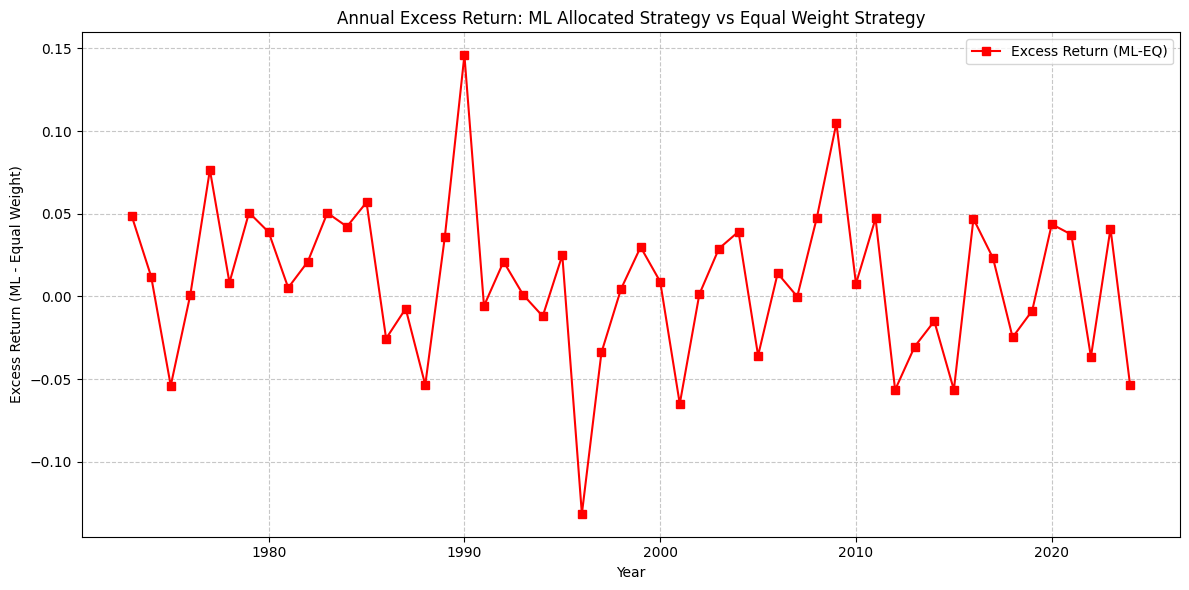

In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Prepare the Data: Create a Year Column from 'Predicted_month' ---
merged_df['Year'] = merged_df['Predicted_month'].dt.year

# --- Function to Calculate Annual Return ---
def annual_return(group, col):
    """
    Compute the annual return as the compounded return over the year.
    """
    return (1 + group[col]).prod() - 1

# --- Compute Annual Returns for Each Strategy by Grouping on 'Year' ---
annual_return_ml = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, 'ML Allocated Strategy Return'))
annual_return_equal = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, 'Equal Factor Weight Strategy'))

# --- Compute Excess Return (ML - Equal Weight) ---
excess_return_ml = annual_return_ml - annual_return_equal

# --- Combine into a DataFrame ---
annual_metrics = pd.DataFrame({
    'ML Annual Return': annual_return_ml,
    'Equal Annual Return': annual_return_equal,
    'Excess Return (ML-EQ)': excess_return_ml
})

# --- Optionally Format the Metrics for Display ---
annual_metrics_formatted = annual_metrics.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else x)
print("Annual Metrics:")
print(annual_metrics_formatted)

# --- Plot Only the Excess Returns ---
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(annual_metrics.index, annual_metrics['Excess Return (ML-EQ)'],
        label='Excess Return (ML-EQ)', color='red', marker='s')
ax.set_xlabel('Year')
ax.set_ylabel('Excess Return (ML - Equal Weight)')
ax.set_title('Annual Excess Return: ML Allocated Strategy vs Equal Weight Strategy')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

<ipython-input-169-c057e9aa49d5>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_return_ml = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, 'ML Allocated Strategy Return'))
<ipython-input-169-c057e9aa49d5>:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_returns_factors[factor] = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, factor))
<ipython-input-169-c057e

Annual Metrics:
      ML Annual Return  SMB Annual Return  Excess Return (ML - SMB)  \
Year                                                                  
1973            0.0487            -0.0397                    0.0885   
1974            0.0986            -0.0061                    0.1047   
1975            0.0037             0.1509                   -0.1471   
1976            0.0944             0.1665                   -0.0721   
1977            0.1607             0.2564                   -0.0957   
1978            0.0654             0.1467                   -0.0813   
1979            0.0815             0.1849                   -0.1033   
1980            0.0049             0.0492                   -0.0443   
1981            0.1090             0.0756                    0.0334   
1982            0.0874             0.0579                    0.0295   
1983            0.1498             0.1023                    0.0475   
1984            0.1159            -0.0798                    

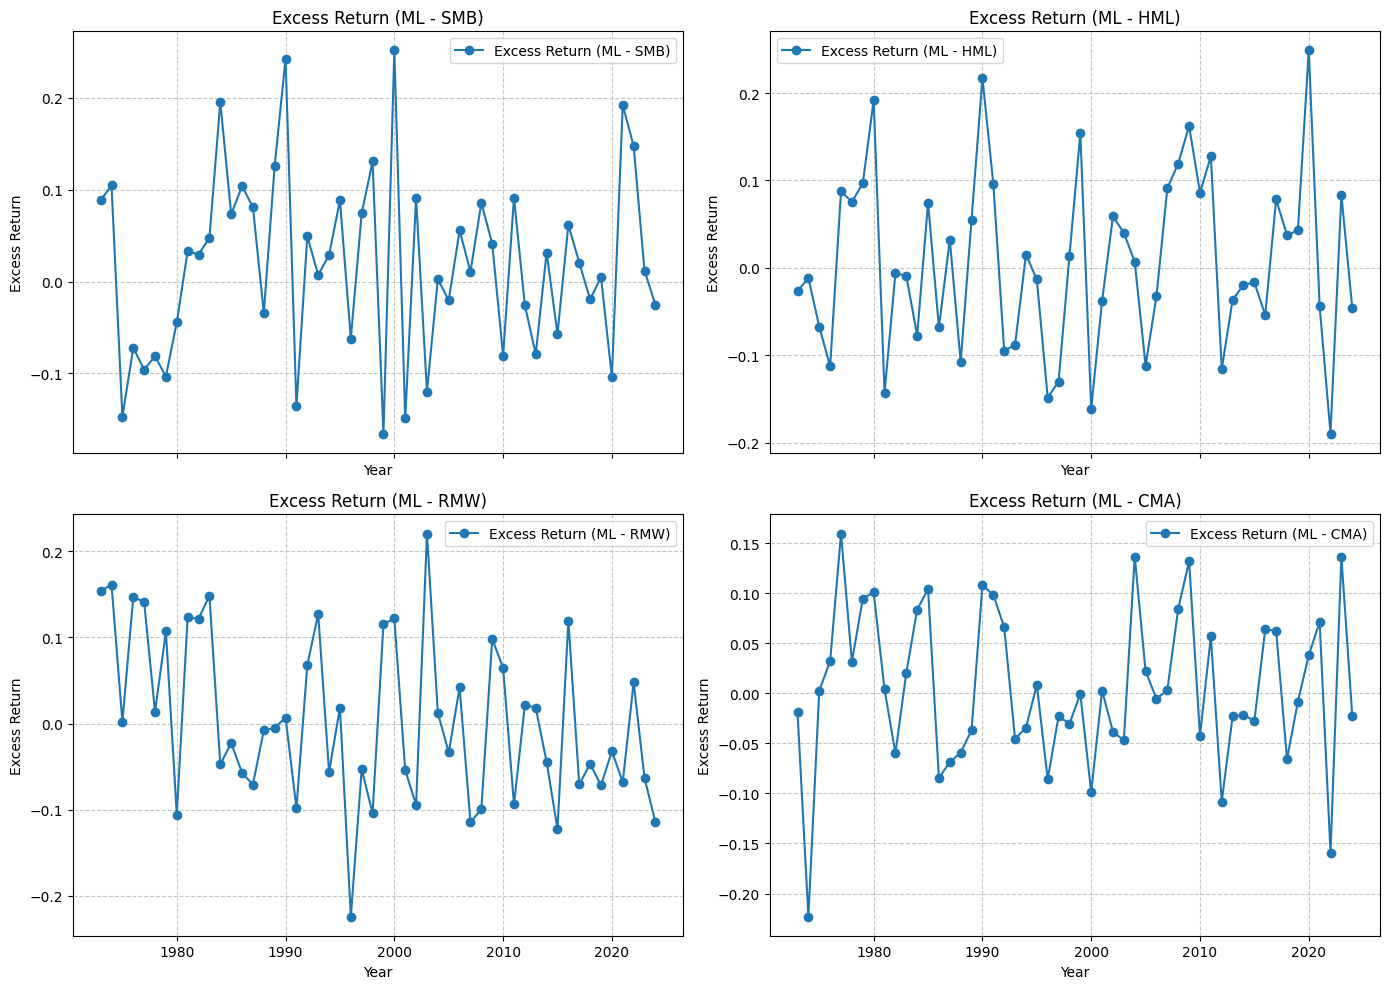

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Prepare the Data: Create a Year Column from 'Predicted_month'
merged_df['Year'] = merged_df['Predicted_month'].dt.year

# --- Function to Calculate Annual Return ---
def annual_return(group, col):
    """
    Compute the annual return as the compounded return over the year.
    """
    return (1 + group[col]).prod() - 1

# --- Compute Annual Returns for the ML Allocated Strategy ---
annual_return_ml = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, 'ML Allocated Strategy Return'))

# --- Compute Annual Returns for Each Factor ---
factor_names = ['SMB', 'HML', 'RMW', 'CMA']
annual_returns_factors = {}
excess_returns = {}

for factor in factor_names:
    annual_returns_factors[factor] = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, factor))
    # Compute excess return: ML strategy annual return minus factor's annual return.
    excess_returns[factor] = annual_return_ml - annual_returns_factors[factor]

# Combine the computed metrics into a DataFrame for reference (optional)
annual_metrics = pd.DataFrame({'ML Annual Return': annual_return_ml})
for factor in factor_names:
    annual_metrics[f'{factor} Annual Return'] = annual_returns_factors[factor]
    annual_metrics[f'Excess Return (ML - {factor})'] = excess_returns[factor]

print("Annual Metrics:")
print(annual_metrics.round(4))

# --- Plot Excess Returns for Each Factor ---
fig, axes = plt.subplots(2, 2, figsize=(14,10), sharex=True)
axes = axes.flatten()

for idx, factor in enumerate(factor_names):
    ax = axes[idx]
    # Plot excess return: ML annual return minus factor annual return.
    ax.plot(excess_returns[factor].index, excess_returns[factor],
            label=f'Excess Return (ML - {factor})', marker='o')
    ax.set_title(f'Excess Return (ML - {factor})')
    ax.set_xlabel('Year')
    ax.set_ylabel('Excess Return')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()

plt.tight_layout()
plt.show()

# Corr Heat map & regiimi sharpet


In [170]:
# # Plot Regime-wise Correlation Heatmaps
#
# For the selected return columns, compute and plot the correlation matrix
# for each market regime as a heatmap.

# %%
# Use the global FACTORS instead of redefining returns_columns
unique_regimes = df[REGIMES_COLUMN].unique()
for regime in unique_regimes:
    regime_data = df[df[REGIMES_COLUMN] == regime][FACTORS]
    corr = regime_data.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f"Return Correlation Heatmap - {regime}")
    plt.tight_layout()
    plt.show()



KeyError: 'Regimes'

In [171]:
# # Plot Sharpe Ratios by Market Regime
#
# Compute and visualize Sharpe ratios for selected factors across each regime,
# as well as the unconditional (all-data) values, using a bar chart.
# The numeric regime codes are converted back to their original names using the regime_mapping,
# and then further shortened using regime_short_mapping.

# %%
# Define factors and regime columns (using global variables if already defined)
factors_columns = df.columns[1:7]  # Adjust the column indices if needed
regimes_column = REGIMES_COLUMN   # Assumes REGIMES_COLUMN was defined earlier

# Use the previously created regime_short_mapping to convert numeric codes back to short names.
# (If a code is not in regime_short_mapping, it will default to "Regime <code>")
regime_short_names = {reg: regime_short_mapping.get(reg, f"Regime {reg}")
                      for reg in df[regimes_column].unique()}

# Calculate Sharpe ratios by regime using a dictionary comprehension and use the short names as keys.
sharpe_ratios = {
    regime_short_names[regime]: (
        df[df[regimes_column] == regime][factors_columns].mean() /
        df[df[regimes_column] == regime][factors_columns].std()
    )
    for regime in df[regimes_column].unique()
}

# Calculate the "Unconditional" Sharpe ratios (using all data)
sharpe_ratios["Unconditional"] = df[factors_columns].mean() / df[factors_columns].std()

# Convert the dictionary to a DataFrame and set column names
sharpe_ratios_df = pd.DataFrame(sharpe_ratios).T
sharpe_ratios_df.columns = factors_columns

# Plot the Sharpe ratios using the same styling as before.
plt.figure(figsize=(14, 8))
sharpe_ratios_df.plot(
    kind="bar",
    grid=True,
    colormap="viridis",
    title="Sharpe Ratios by Regime and Unconditional",
    figsize=(14, 8)
)
plt.ylabel("Sharpe Ratio", fontsize=12)
plt.xlabel("Market Regimes", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Factors", fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


KeyError: 'Regimes'

In [172]:
# --- Code cell: Export results to CSV ---

import pandas as pd

# 1) Merge the monthly ML strategy returns (from merged_df) into results_df
#    so that we have both "ML Allocated Strategy Return" and "Allocated_Return"
df_with_ml = pd.merge(
    results_df,
    merged_df[['Predicted_month', 'ML Allocated Strategy Return']],
    on='Predicted_month',
    how='left'
)

# 2) Merge the factor returns and benchmark from the original df
#    so that we have columns for each factor's monthly returns.
factor_columns = [
    'USA MOMENTUM Standard (Large+Mid Cap)',
    'USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)',
    'USA RISK WEIGHTED Standard (Large+Mid Cap)',
    'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)',
    'USA ENHANCED VALUE Standard (Large+Mid Cap)'
]
benchmark_col = 'USA Standard (Large+Mid Cap)'

df_with_factors = pd.merge(
    df_with_ml,
    df[['Date', benchmark_col] + factor_columns],
    left_on='Predicted_month',
    right_on='Date',
    how='left'
)

# 3) Identify the probability columns (those ending with '_prob', e.g. "Momentum_prob")
probability_columns = [col for col in df_with_factors.columns if col.endswith('_prob')]

# 4) Select and rename columns for clarity in the final CSV
#    Required columns (in order):
#       date
#       benchmark
#       return (ML strategy monthly return)
#       factor returns (one column per factor)
#       winning probabilities (one column per factor-prob)
#       allocated return (from the RF model)
columns_for_csv = [
    'Predicted_month',            # date
    benchmark_col,                # benchmark
    'ML Allocated Strategy Return',    # ML strategy's monthly return
] + factor_columns + probability_columns + [
    'Allocated_Return'            # allocated return from the classifier's probabilities
]

df_export = df_with_factors[columns_for_csv].copy()

# Rename the columns to match your exact specification
df_export = df_export.rename(columns={
    'Predicted_month': 'Date',
    benchmark_col:     'Benchmark_Return',
    'ML Allocated Strategy Return': 'ML_Strategy_Return',
    'Allocated_Return': 'Allocated_Return'
})

# 5) Export the DataFrame to CSV with ';' as the separator
output_filename = 'model_verification.csv'
df_export.to_csv(output_filename, sep=';', index=False)

print(f"CSV file '{output_filename}' has been created with the following columns:")
print(df_export.columns.tolist())
print("\nPreview:")
display(df_export.head(10))


KeyError: "['USA Standard (Large+Mid Cap)', 'USA MOMENTUM Standard (Large+Mid Cap)', 'USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)', 'USA RISK WEIGHTED Standard (Large+Mid Cap)', 'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)', 'USA ENHANCED VALUE Standard (Large+Mid Cap)'] not in index"